# Time Series Analysis
by Chee-Foong
on 16 Mar 2020

## Libraries

In [264]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

import sys  
sys.path.append('../src') 
from edge import *

In [2]:
import requests
import json
import pandas as pd
import numpy as np
import calendar

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(14,10), 'figure.dpi':120})

## Data Preparation
<span style="color:red">*Refer to data exploratory notebook for data sanity check and analysis*</span>


In [212]:
full_data = pd.read_csv('../data/full_data_cleaned.csv', parse_dates=['datetime'], index_col='datetime')
full_data = full_data.apply(pd.to_numeric) 
full_data.sort_index(inplace=True)
full_data.shape

(29568, 3)

In [214]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29568 entries, 2014-09-29 00:30:00 to 2016-06-06 00:00:00
Data columns (total 3 columns):
system_demand_actual    29568 non-null int64
nem_demand_actual       29568 non-null int64
nem_demand_forecast     29568 non-null int64
dtypes: int64(3)
memory usage: 924.0 KB


## Time Series Analysis
The analysis follows the **Box-Jenkins Method** documented here: 
- https://ncss-wpengine.netdna-ssl.com/wp-content/themes/ncss/pdf/Procedures/NCSS/The_Box-Jenkins_Method.pdf

For simplicity, the following analysis will focus on 1 week of weekdays data and to build a model based on data from Mon to Thu and forecast the energy demand for Fri.

The model will serve as a baseline model which can be finetuned to predict energy demand over weekends/holidays.

In [215]:
demand_data_analysis = demand_data['2015-05-04':'2015-05-07'].copy()
demand_data_analysis.shape

(192, 3)

Check whether the time series is stationary using the **augmented dicky-fuller test**

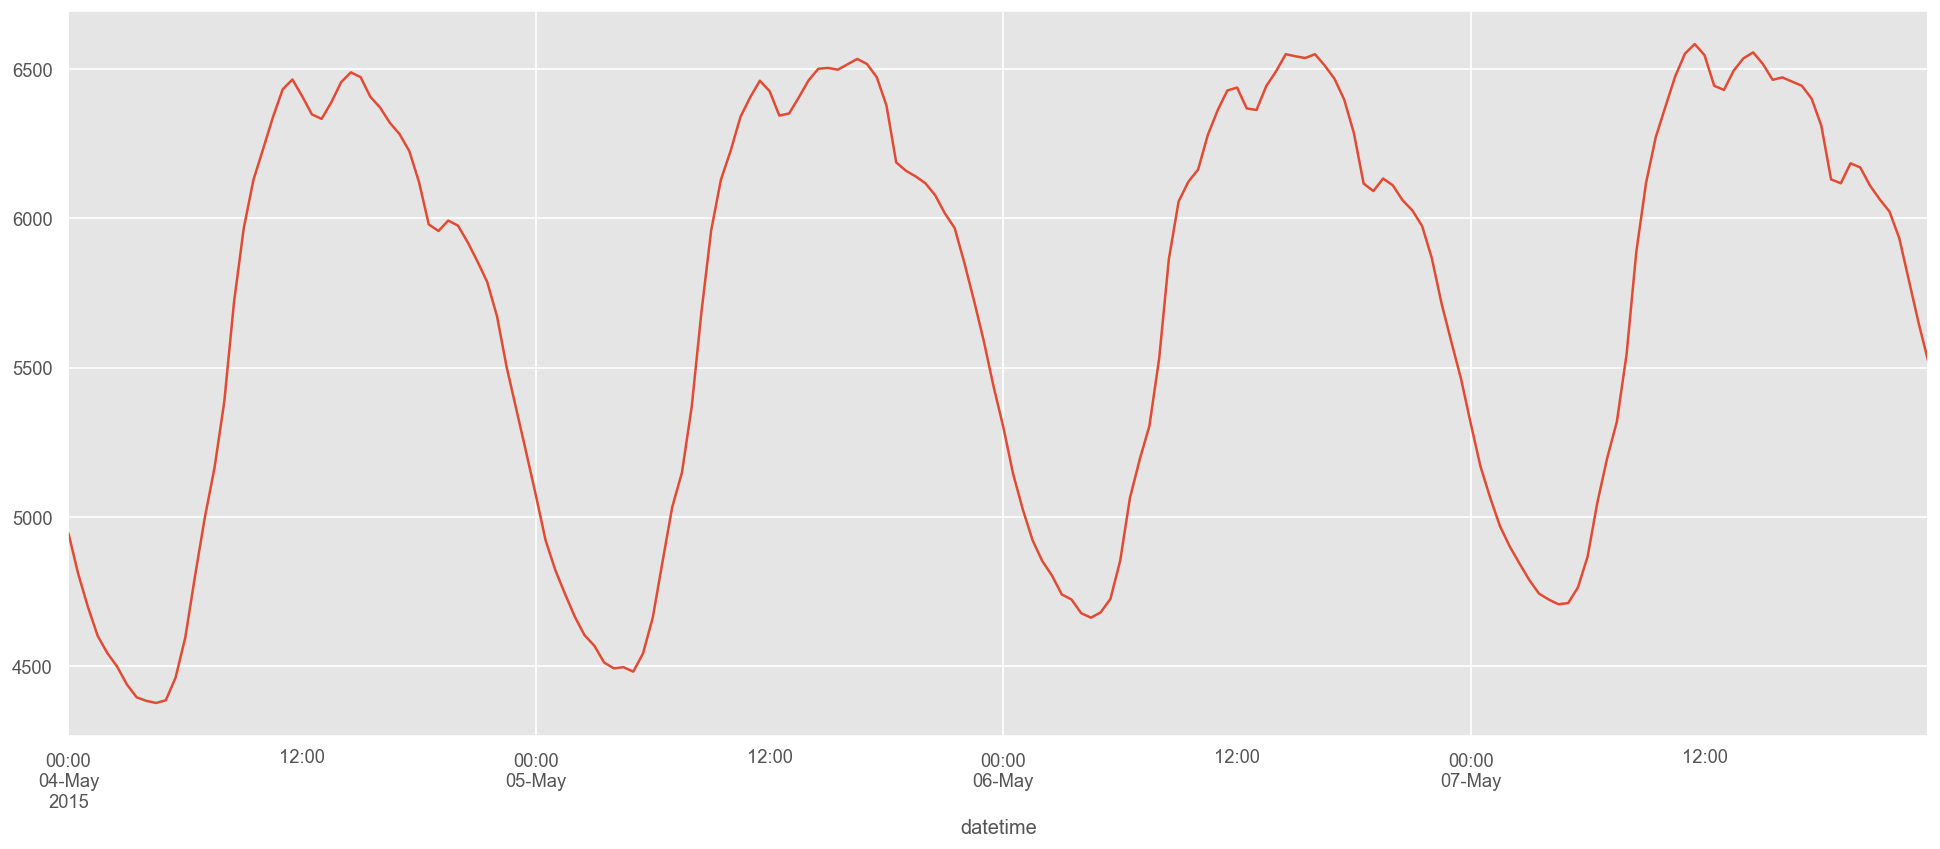

ADF Statistic: -4.289715765397449
p-value: 0.00046278506266978707


In [216]:
# Import augmented dicky-fuller test function
from statsmodels.tsa.stattools import adfuller

plt.figure(figsize=FIG_SIZE)

# # Plot time series
demand_data_analysis.nem_demand_actual.plot()
plt.show()

# Run Dicky-Fuller test
result = adfuller(demand_data_analysis.nem_demand_actual)

# Print the test statistic and the p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])

**ADF Test Statistic** → 0th element
- More negative means more likely to be stationary

**P-Value** → 1st element
- If p-value is small (< 0.05) → reject null hypothesis. Reject non-stationary.

It is inconclusive whether the time series is stationary although the p-value points to rejecting the null hypothesis that the time series is stationary.

### ARIMA Model Identification

Take a look at the **PACF and ACF** without differencing.  

We will use the ACF and PACF to decide whether some data is best suited to an MA model or an AR model. Selecting the right model order is of great importance to our predictions.  For different types of models we expect the following behavior in the ACF and PACF:

Model|AR(p)|MA(q)|ARMA(p,q)
--|--|--|--
ACF|Tails off|Cuts off after lag q|Tails off
PACF|Cuts off after lag p|Tails off|Tails off


/Users/chancheefoong/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


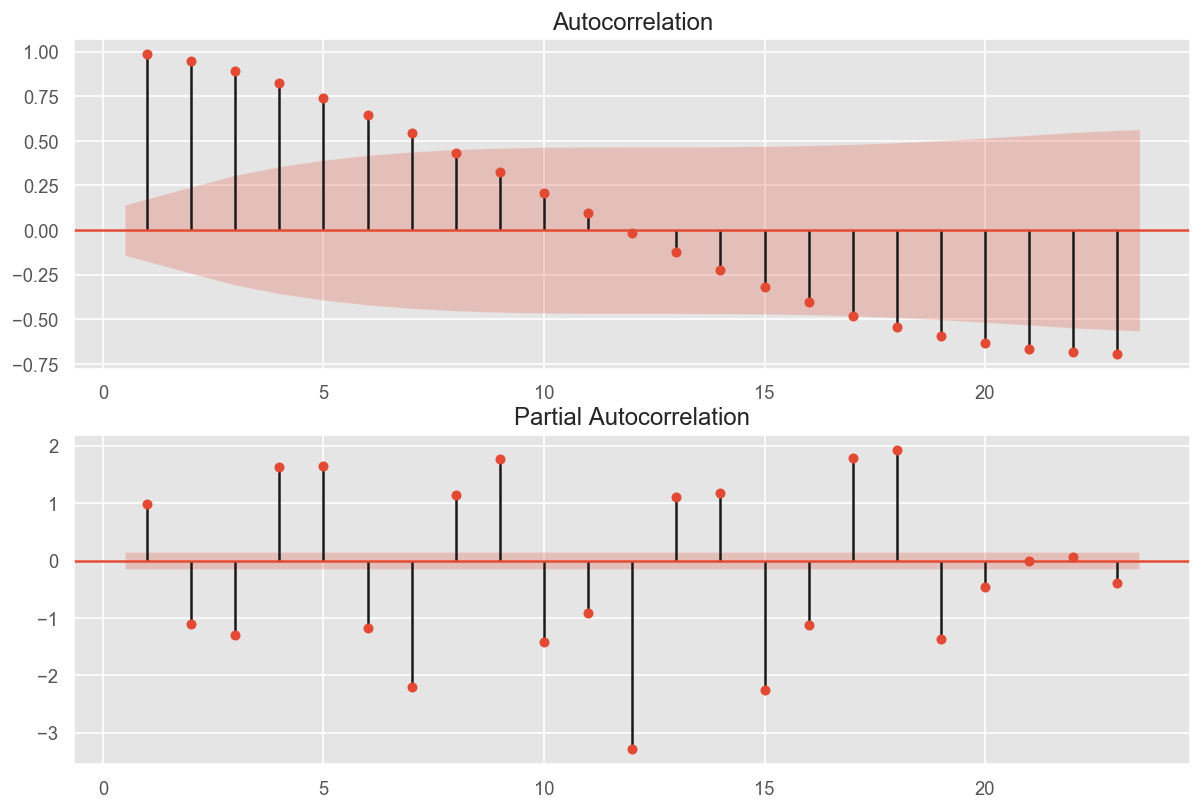

In [217]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Import data
series = demand_data_analysis.nem_demand_actual.interpolate().reset_index(drop=True)

# Create figure
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
 
# Plot the ACF of savings on ax1
plot_acf(demand_data_analysis.nem_demand_actual, zero=False, ax=ax1)

# Plot the PACF of savings on ax2
plot_pacf(demand_data_analysis.nem_demand_actual, zero=False, ax=ax2)

plt.show()

The PACF plot does not tails off.  Possibly due to the time series not being stationary.

### Transforming time series by differencing
With differencing, we aim to transform the time series to be stationary.

/Users/chancheefoong/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/Users/chancheefoong/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


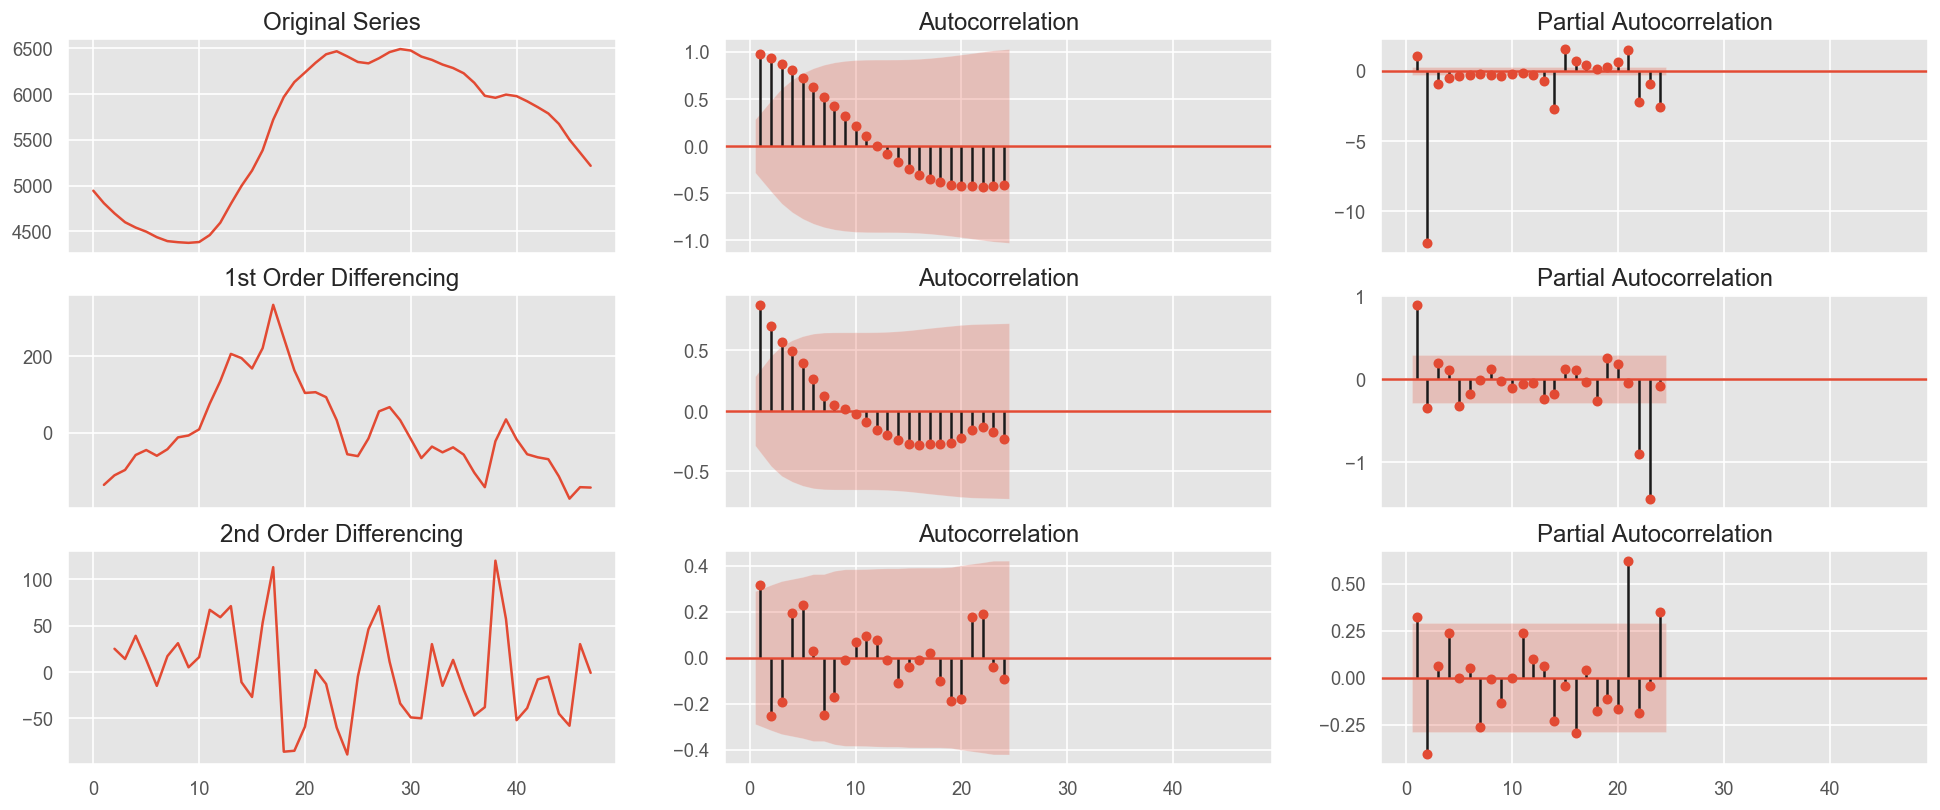

In [231]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# ACF_LAGS = demand_data_analysis.shape[0] - 10
ACF_LAGS = 24

# Import data
series = demand_data_analysis.nem_demand_actual.reset_index(drop=True)[0:ACF_LAGS*2]

# Original Series
fig, axes = plt.subplots(3, 3, sharex=True)
axes[0, 0].plot(series); axes[0, 0].set_title('Original Series')
plot_acf(series, lags=ACF_LAGS, zero=False, ax=axes[0, 1])
plot_pacf(series, lags=ACF_LAGS, zero=False, ax=axes[0, 2])

# 1st Differencing
axes[1, 0].plot(series.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(series.diff().dropna(), lags=ACF_LAGS, zero=False, ax=axes[1, 1])
plot_pacf(series.diff().dropna(), lags=ACF_LAGS, zero=False, ax=axes[1, 2])

# 2nd Differencing
axes[2, 0].plot(series.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(series.diff().diff().dropna(), lags=ACF_LAGS, zero=False, ax=axes[2, 1])
plot_pacf(series.diff().diff().dropna(), lags=ACF_LAGS, zero=False, ax=axes[2, 2])

plt.show()

Conservatively, 1st order differencing looks sufficient.

In [220]:
# from pmdarima.arima.utils import ndiffs

# ## Adf Test
# print(ndiffs(series, test='adf')) # 2

# # KPSS test
# print(ndiffs(series, test='kpss'))  # 0

# # PP test:
# print(ndiffs(series, test='pp')) # 2

### Choosing the p and q for the ARIMA model with differencing = 1

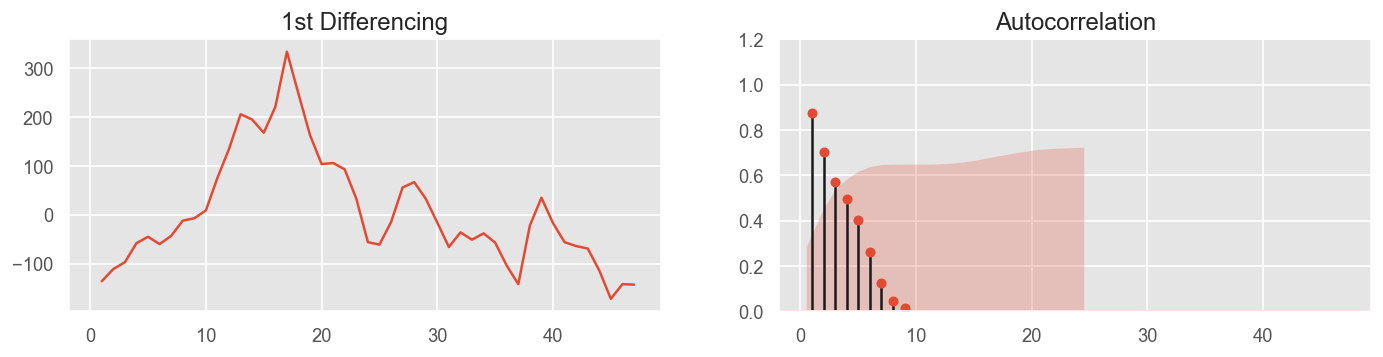

In [234]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(14,3))
axes[0].plot(series.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(series.diff().dropna(), ax=axes[1], lags=ACF_LAGS, zero=False)

plt.show()

/Users/chancheefoong/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


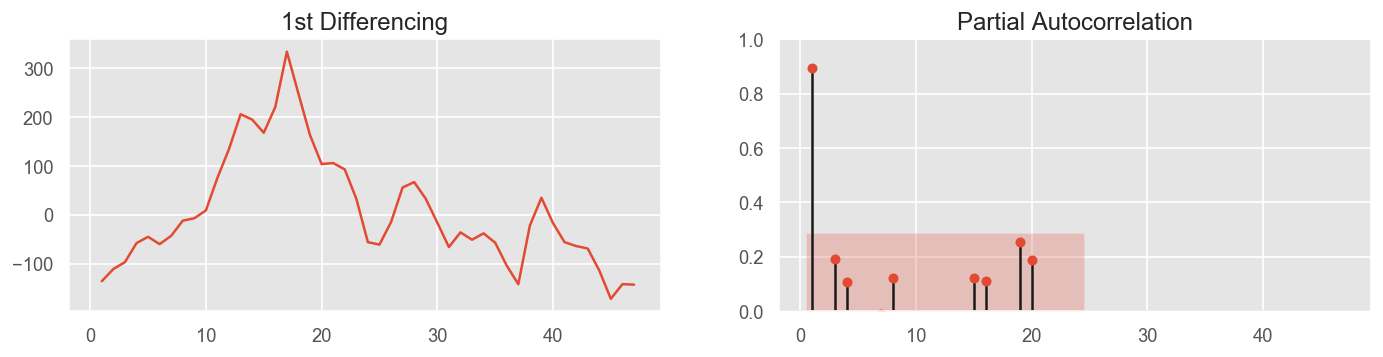

In [236]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(14,3))
axes[0].plot(series.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1))
plot_pacf(series.diff().dropna(), ax=axes[1], lags=ACF_LAGS, zero=False)

plt.show()

Choosing the following to build the ARIMA model
- d = 1
- p = 1
- q = 1

That is **ARIMA(1,1,1)** model

### Introducing SARIMAX Model
Given the time series has seasonality effect, we will build a SARIMAX model.  We will also iterate through the model parameters to find the best model based on BIC or AIC.

Notes:
1. BIC favors simpler models than AIC
2. AIC is better at choosing predictive models
3. BIC is better at choosing good explanatory mode

Working on the non-seasonal parameters first:
1. p: from 0 to 3
2. d: from 1 to 2
3. q: from 0 to 3

In [237]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Import data
series = demand_data_analysis.nem_demand_actual.reset_index(drop=True)

# Create empty list to store search results
order_aic_bic=[]

for p in range(4):
    for q in range(4):
        for d in range(1,3):
            print('Processing {},{},{}...'.format(p,d,q))
            # create and fit ARMA(p,d,q) model
            model = SARIMAX(series, order=(p,d,q))
            results = model.fit()

            # Append order and results tuple
            order_aic_bic.append((p, d, q, results.aic, results.bic))

# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic, columns=['p', 'd', 'q', 'AIC', 'BIC'])

Processing 0,1,0...
Processing 0,2,0...
Processing 0,1,1...
Processing 0,2,1...
Processing 0,1,2...
Processing 0,2,2...
Processing 0,1,3...


/Users/chancheefoong/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Processing 0,2,3...
Processing 1,1,0...
Processing 1,2,0...
Processing 1,1,1...
Processing 1,2,1...
Processing 1,1,2...
Processing 1,2,2...
Processing 1,1,3...
Processing 1,2,3...
Processing 2,1,0...
Processing 2,2,0...
Processing 2,1,1...
Processing 2,2,1...
Processing 2,1,2...
Processing 2,2,2...
Processing 2,1,3...


/Users/chancheefoong/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Processing 2,2,3...
Processing 3,1,0...
Processing 3,2,0...
Processing 3,1,1...
Processing 3,2,1...
Processing 3,1,2...
Processing 3,2,2...
Processing 3,1,3...
Processing 3,2,3...


In [238]:
# Print order_df in order of increasing AIC
order_df.sort_values('AIC').head()

,p,d,q,AIC,BIC
23,2,2,3,2024.059358,2043.541502
31,3,2,3,2024.901022,2047.630191
30,3,1,3,2026.644036,2049.409950
22,2,1,3,2029.722849,2049.236489
17,2,2,0,2032.903858,2042.644931


In [239]:
# Print order_df in order of increasing BIC
order_df.sort_values('BIC').head()

,p,d,q,AIC,BIC
17,2,2,0,2032.903858,2042.644931
23,2,2,3,2024.059358,2043.541502
31,3,2,3,2024.901022,2047.630191
25,3,2,0,2034.901703,2047.889799
19,2,2,1,2034.902436,2047.890532


Best Model based on AIC is **ARIMA(2,2,3)** 

## Model Diagnostics

In [240]:
# Fit model
model = SARIMAX(series, order=(2,2,3))
results = model.fit()

# Assign residuals to variable
residuals = results.resid

How far our the predictions from the real values?

In [241]:
mae = np.mean(np.abs(residuals))
mae

76.2756395774209

If the model fits well the residuals will be white Gaussian noise

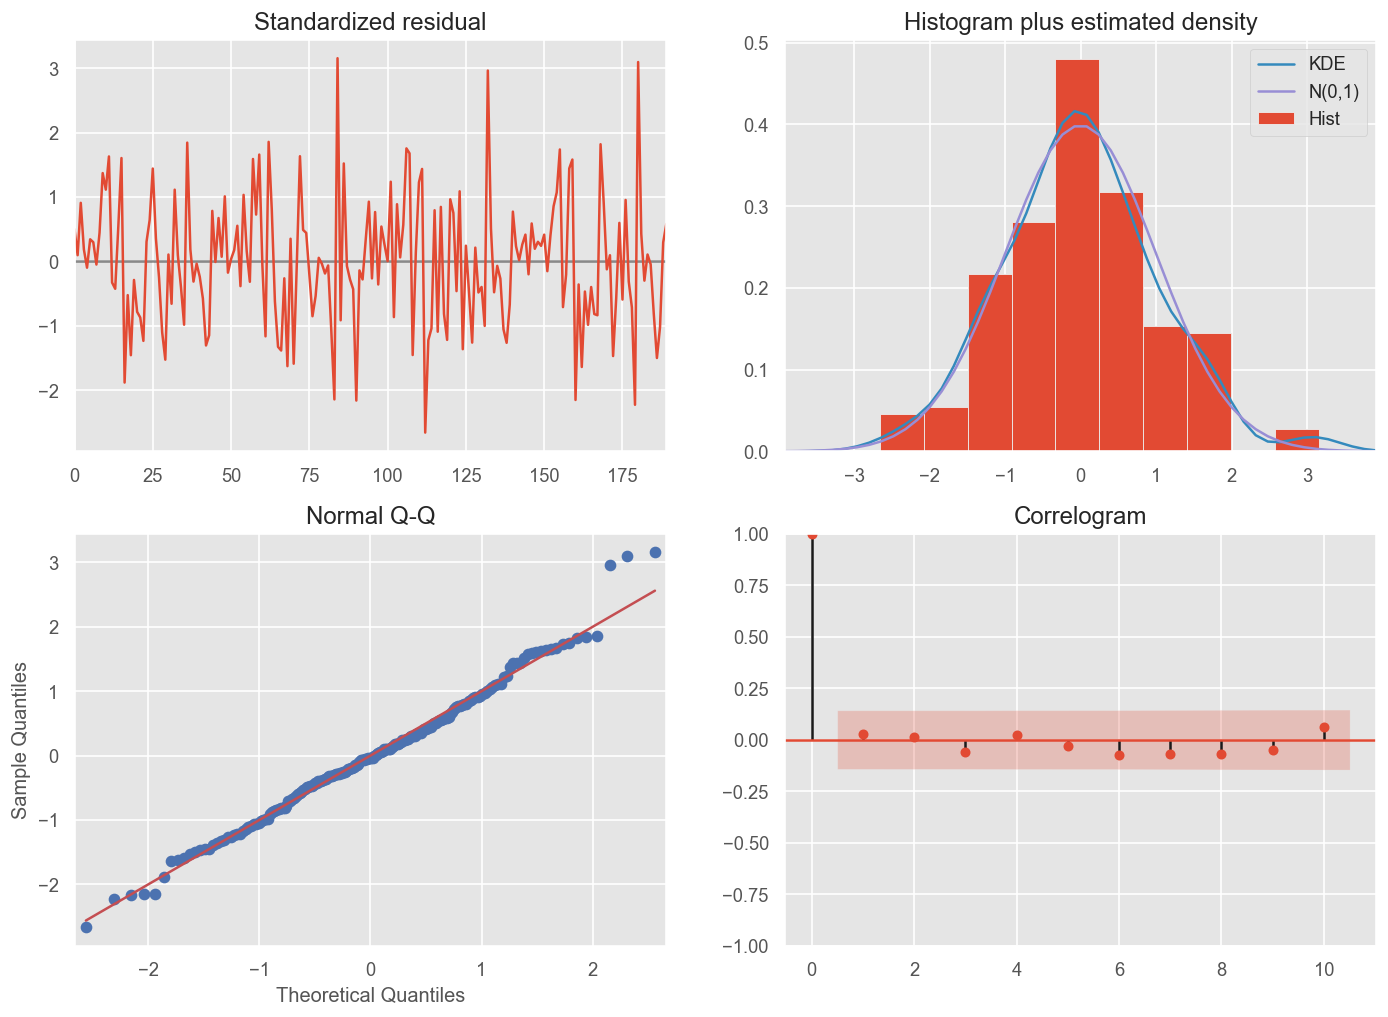

In [242]:
# Create the 4 diagostics plots
results.plot_diagnostics(figsize=(14,10))
plt.show()

If the 2 measures below are below 0.05, we will reject the null hypothesis

Test | Null hypothesis | P-value name | What the p-value mean
--| -- |-- | --
Ljung-Box|There are no correlations in the residual|Prob(Q)|p-value less than 0.05 then REJECT null hypothesis that residuals are uncorrelated 
Jarque-Bera|The residuals are normally distributed|Prob(JB)|p-value less than 0.05 then REJECT null hypothesis that residuals are normal

If any of the null hypothesis is rejected, model can be improved.


In [91]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      nem_demand_actual   No. Observations:                  384
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -2021.706
Date:                Wed, 18 Mar 2020   AIC                           4051.411
Time:                        02:01:31   BIC                           4067.203
Sample:                             0   HQIC                          4057.676
                                - 384                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8549      0.042     20.365      0.000       0.773       0.937
ma.L1          0.2870      0.077      3.734      0.000       0.136       0.438
ma.L2         -0.1616      0.063     -2.566      0.010      -0.285      -0.038
sigma2      2231.7221    139.653     15.980      0.000    1958.007    2505.437
===================================================================================
Ljung-Box (Q):                      176.38   Jarque-Bera (JB):                53.11
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.80
Prob(H) (two-sided):                  0.41   Kurtosis:                         3.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Model can be improved.  Let's look at the seasonality paramters.

### How about Seasonal Decomposition?

#### Time Series Decomposition
The frequency of decomposition must be an interval, which 'may' repeat. So we have data with 30min frequency and we are looking for a daily repetition of behavior.

$decompfreq = \cfrac{24h \cdot 60min}{30min} \cdot 1day$

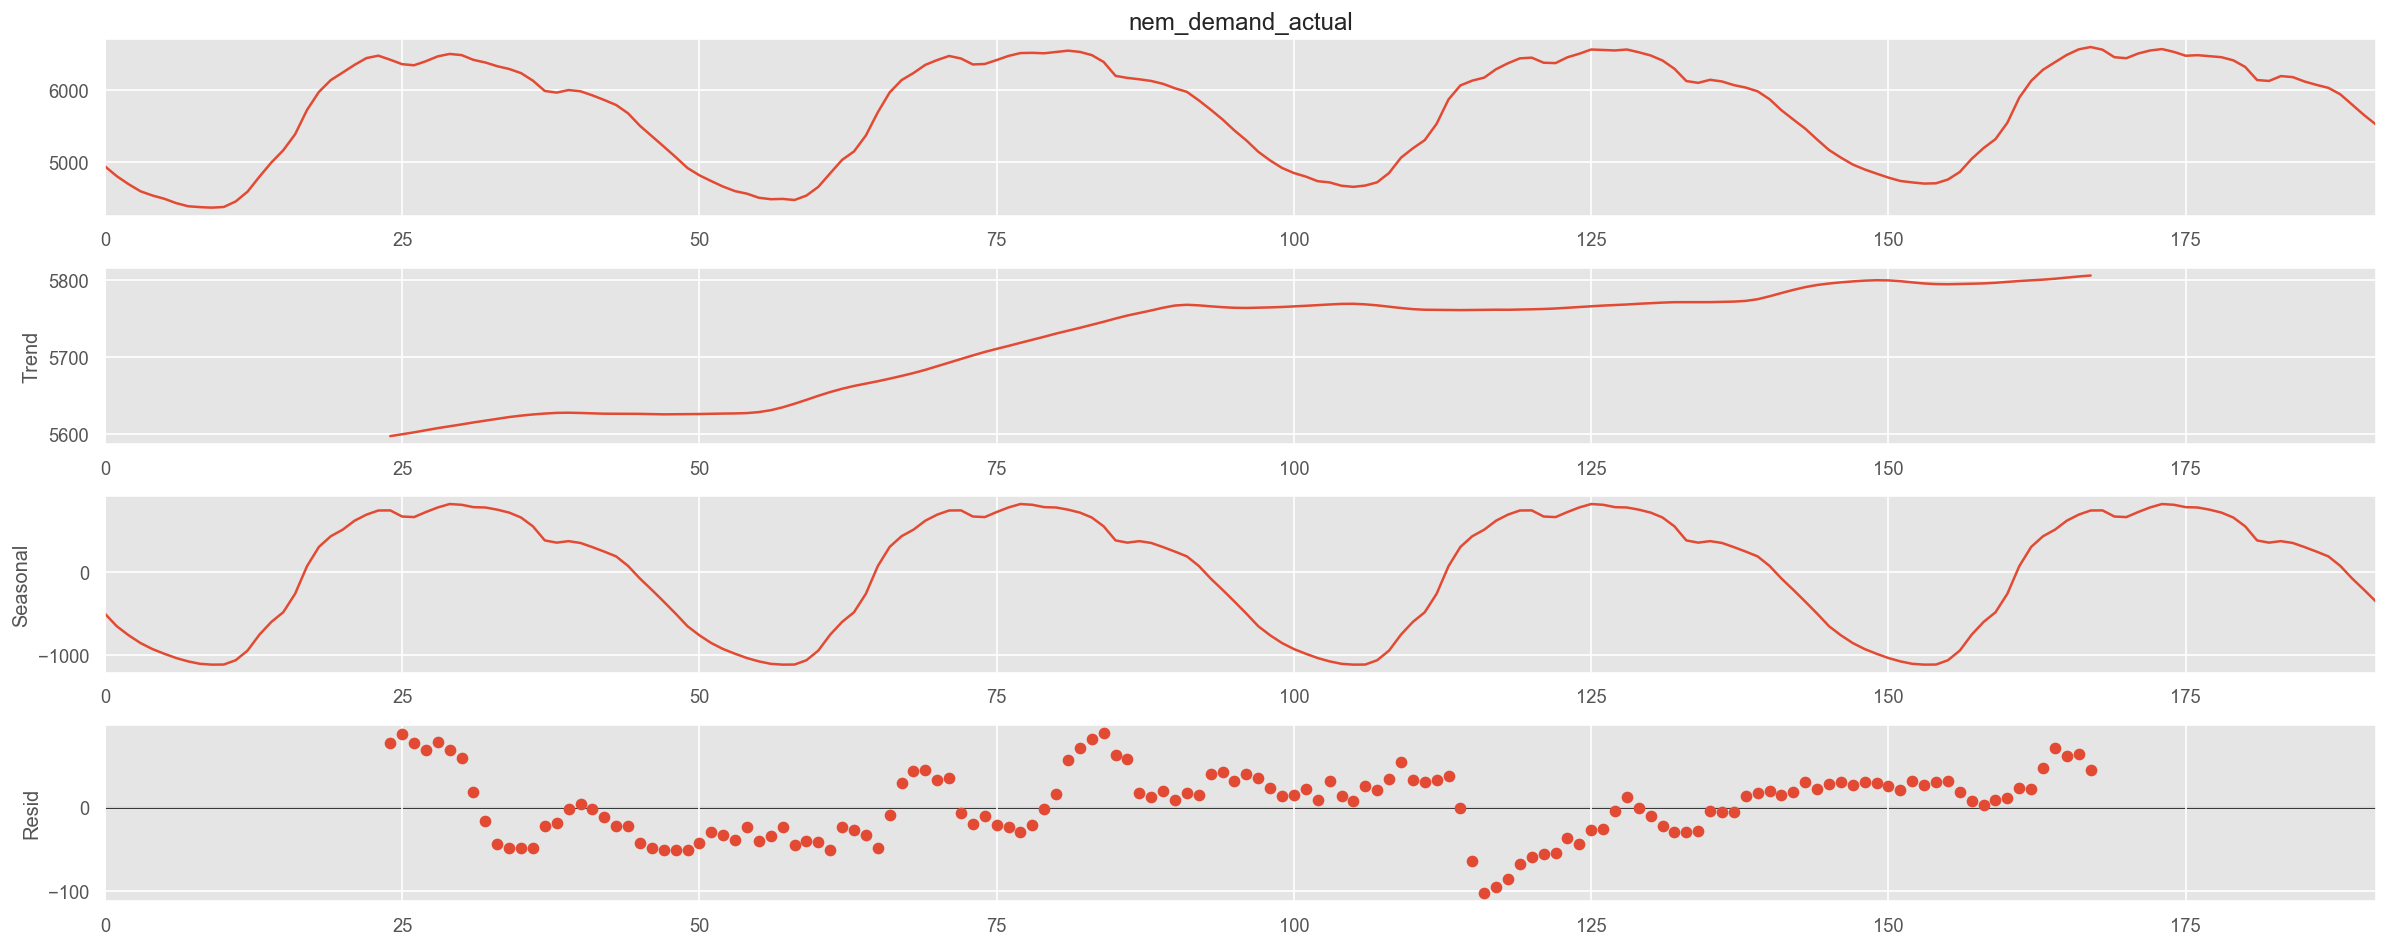

In [243]:
import pylab
pylab.rcParams['figure.figsize'] = FIG_SIZE

# Import data
series = demand_data_analysis.nem_demand_actual.interpolate().reset_index(drop=True)

from statsmodels.tsa.seasonal import seasonal_decompose

decompfreq = int(24*60/30*1)

decomp_results = seasonal_decompose(series, freq=decompfreq, model='additive')

decomp_results.plot()
plt.show()

# fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(14,5), sharex=True)
# decomp_results.trend.plot(ax=ax1)
# ax1.set_ylabel("Trend")
# decomp_results.seasonal.plot(ax=ax2)
# ax2.set_ylabel("Seasonal")
# decomp_results.resid.plot(ax=ax3)
# ax3.set_ylabel("Residual")
# plt.show()

### Selecting the seasonality parameters (P,D,Q) for the SARIMAX model
The following parameters are fixed during the iteration:
1. (p,d,q) = (2,2,3)
2. Seasonal Frequency: 48 (48 x 30min for each day, time series to repeat every day)

Parameters to iterate:
1. P: from 0 to 3
2. D: 0 *(Sum of D and d cannot be > 2)*
3. Q: from 0 to 3

In [245]:
print('Seasonal Frequency is {} steps'.format(decompfreq))

Seasonal Frequency is 48 steps


<span style="color:red">**Warning:  Below may take long time to run.**</span>

In [265]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

DIFF = decompfreq
ns_order = (2,2,3)

# Import data
series = demand_data_analysis.nem_demand_actual.interpolate().reset_index(drop=True)

# Create empty list to store search results
order_aic_bic_seasonal=[]

for P in range(4):
    for Q in range(4):
        for D in range(1):
            print('Processing {},{},{}...'.format(P,D,Q))

            # create and fit SARIMAX(p,d,q,P,D,Q,DIFF) model
            model = SARIMAX(series, order=ns_order, seasonal_order=(P,D,Q,DIFF))
            try:
                results = model.fit()

                # Append order and results tuple
                order_aic_bic_seasonal.append((P, D, Q, results.aic, results.bic))
            except:
                pass
            
# Construct DataFrame from order_aic_bic
order_seasonal_df = pd.DataFrame(order_aic_bic_seasonal, columns=['P', 'D', 'Q', 'AIC', 'BIC'])

Processing 0,0,0...
Processing 0,0,1...
Processing 0,0,2...
Processing 0,0,3...
Processing 1,0,0...
Processing 1,0,1...
Processing 1,0,2...
Processing 1,0,3...
Processing 2,0,0...
Processing 2,0,1...
Processing 2,0,2...
Processing 2,0,3...
Processing 3,0,0...
Processing 3,0,1...
Processing 3,0,2...
Processing 3,0,3...


In [272]:
order_seasonal_df.sort_values('AIC').head()

,P,D,Q,AIC,BIC
9,3,0,3,1833.327901,1872.292190
6,3,0,0,1843.089120,1872.312336
7,3,0,1,1845.007555,1877.477796
4,1,0,1,1845.676210,1871.652402
5,1,0,2,1846.619139,1875.842356


In [273]:
order_seasonal_df.sort_values('BIC').head()

,P,D,Q,AIC,BIC
4,1,0,1,1845.676210,1871.652402
9,3,0,3,1833.327901,1872.292190
6,3,0,0,1843.089120,1872.312336
5,1,0,2,1846.619139,1875.842356
7,3,0,1,1845.007555,1877.477796


Best Model based on AIC is **SARIMAX(2,2,3)x(2,0,3)** with Seasonal Frequency of 48 

In [274]:
# Create a SARIMAX model
model = SARIMAX(series, order=(2,2,3), seasonal_order=(2,0,3,DIFF))

# Fit the model
results = model.fit()

# Print the results summary
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                  nem_demand_actual   No. Observations:                  192
Model:             SARIMAX(2, 2, 3)x(2, 0, 3, 48)   Log Likelihood                -903.543
Date:                            Wed, 18 Mar 2020   AIC                           1829.086
Time:                                    20:41:52   BIC                           1864.804
Sample:                                         0   HQIC                          1843.555
                                            - 192                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2179      0.289      0.754      0.451      -0.348       0.784
ar.L2          0.4873      0.163   

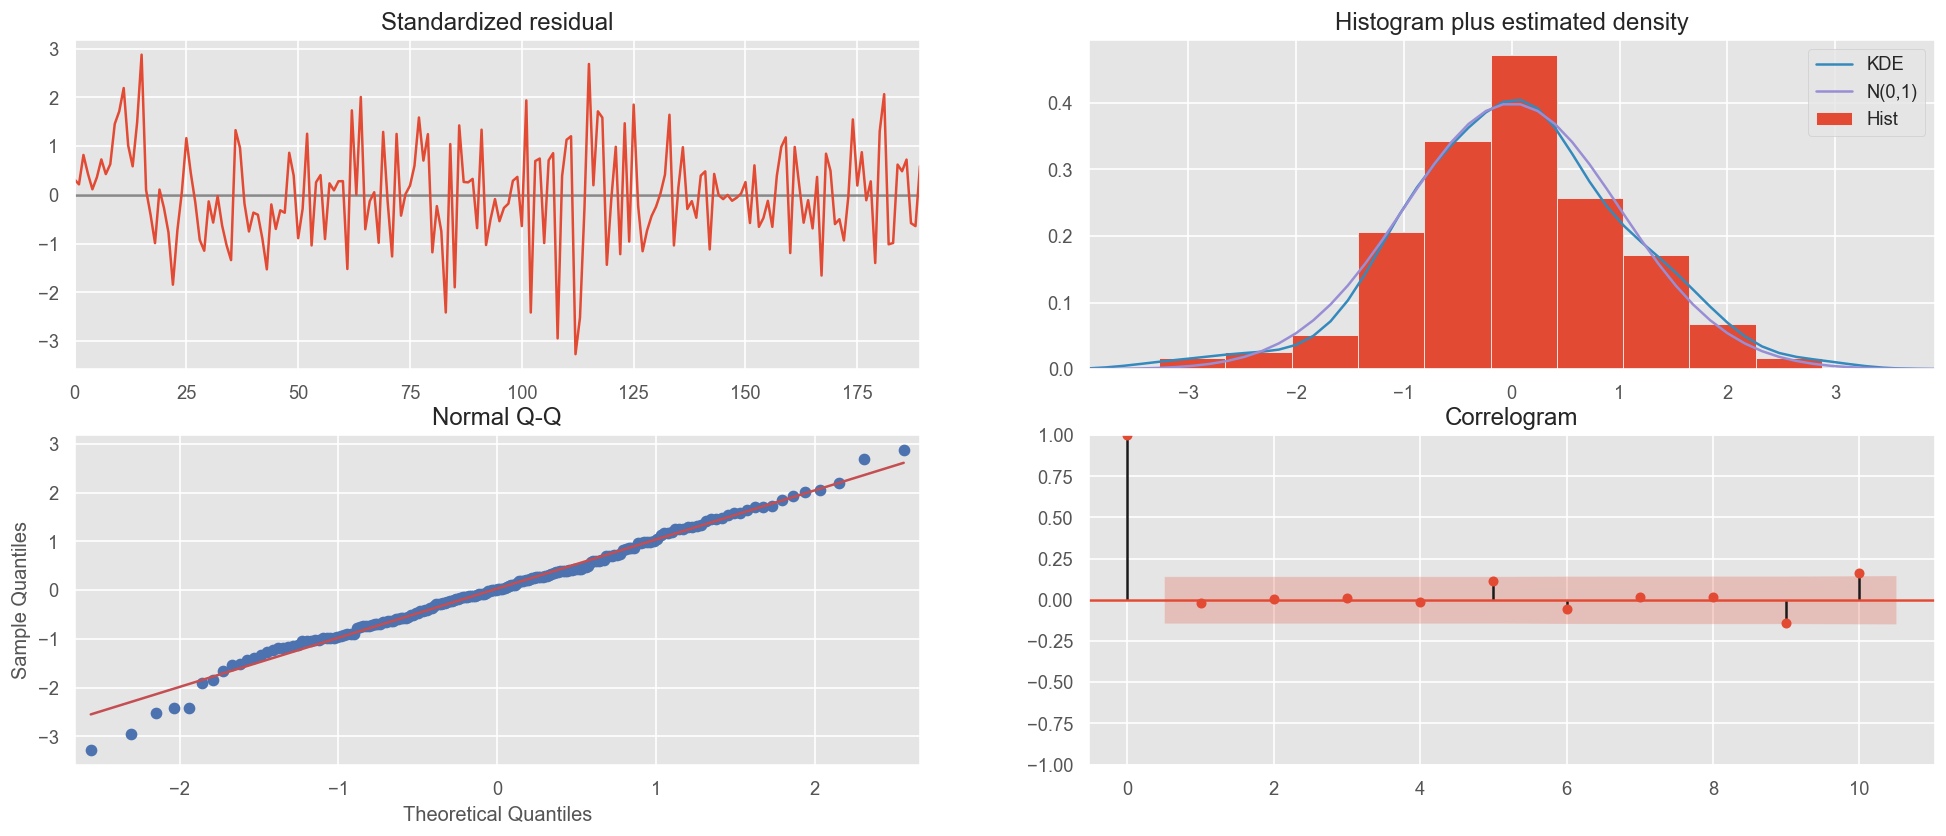

In [275]:
results.plot_diagnostics(figsize=FIG_SIZE)
plt.show()

### Using pmdarima library to search for the best SARIMAX model
Pmdarima (originally pyramid-arima, for the anagram of 'py' + 'arima') is a statistical library designed to fill the void in Python's time series analysis capabilities.

In [276]:
import pmdarima as pm

Fixing the following parameters:
1. p: from 0 to 3
2. d: 2
3. q: from 0 to 3
4. P: from 0 to 3
5. D: 0
6. Q: from 0 to 3
7. Seasonality Frequency: 48

In [277]:
results_auto = pm.auto_arima(series, d=2, start_p=0, start_q=0, max_p=3, max_q=3, # non-seasonal arguments
                        seasonal=True, m=48, D=0, start_P=0, start_Q=0, max_P=3, max_Q=3,
                        information_criterion='aic', # used to select best model
                        trace=True,                  # print results whilst training
                        error_action='ignore',       # ignore orders that don't work
                        stepwise=True,)

print(results_auto.summary())

Performing stepwise search to minimize aic
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 48) (constant=True); AIC=2065.492, BIC=2071.986, Time=0.012 seconds
Fit ARIMA: (1, 2, 0)x(1, 0, 0, 48) (constant=True); AIC=1888.631, BIC=1901.620, Time=2.031 seconds
Near non-invertible roots for order (1, 2, 0)(1, 0, 0, 48); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Fit ARIMA: (0, 2, 1)x(0, 0, 1, 48) (constant=True); AIC=1977.070, BIC=1990.058, Time=1.998 seconds
Near non-invertible roots for order (0, 2, 1)(0, 0, 1, 48); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 48) (constant=False); AIC=2063.492, BIC=2066.739, Time=0.007 seconds
Fit ARIMA: (0, 2, 0)x(1, 0, 0, 48) (constant=True); AIC=1894.151, BIC=1903.892, Time=1.064 seconds
Near non-invertible roots for order (0, 2, 0)(1, 0, 0, 48); setting score to inf (at least one inverse root too close to the border of the unit

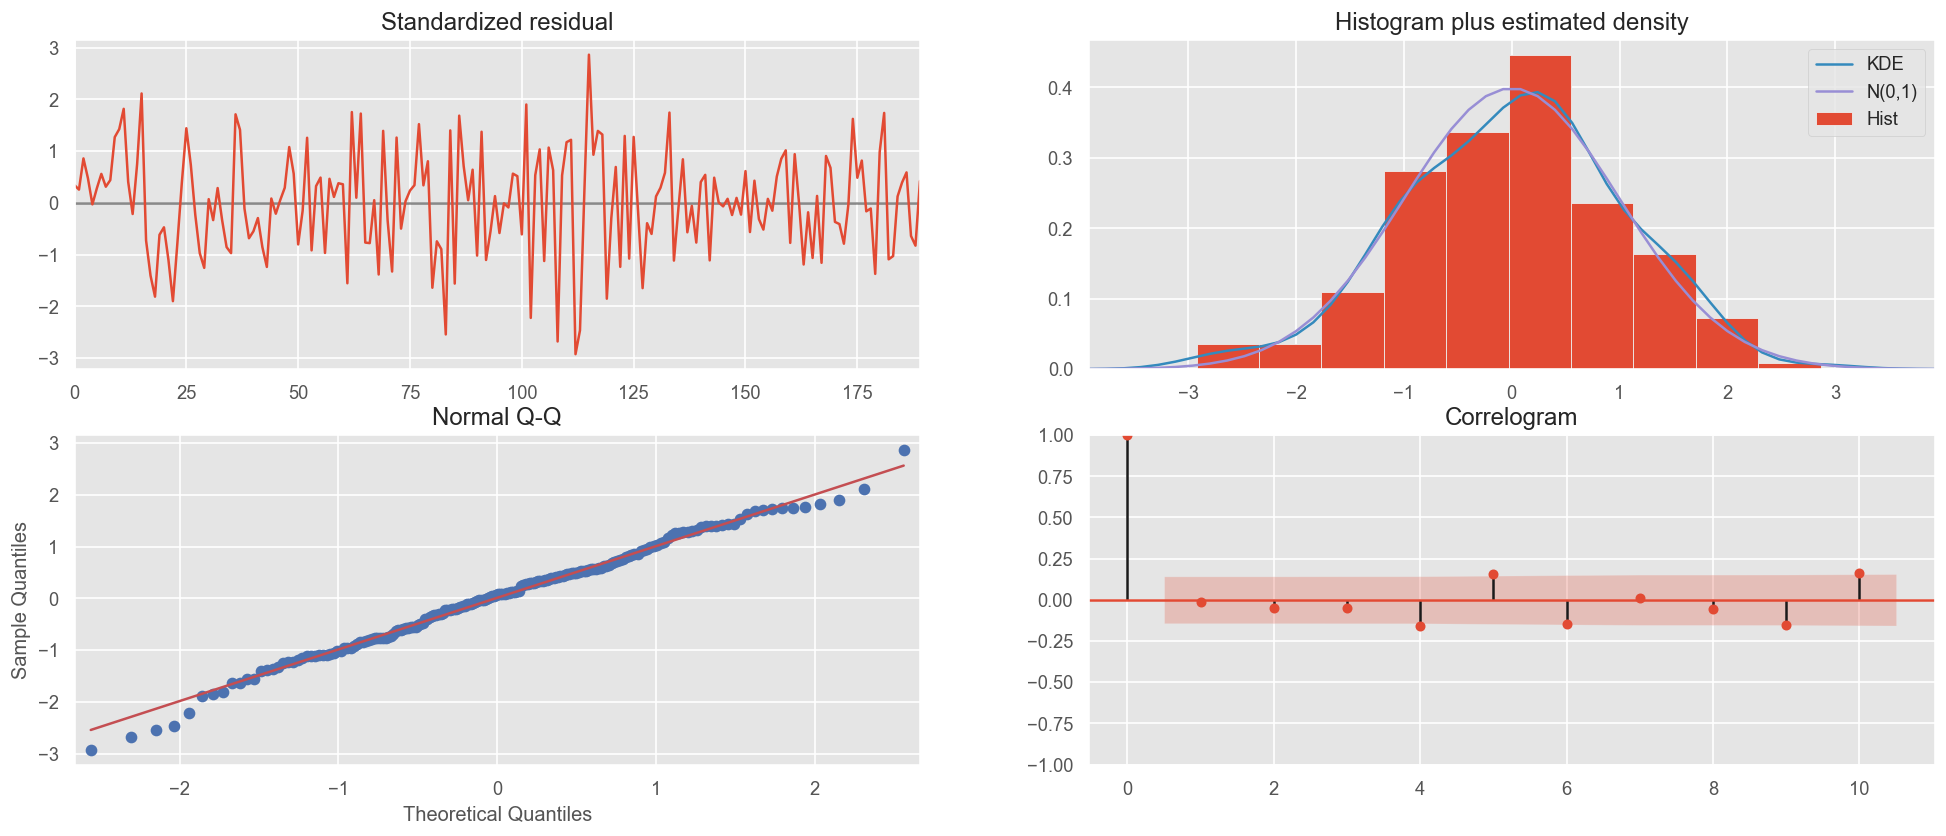

In [278]:
results_auto.plot_diagnostics(figsize = FIG_SIZE)
plt.show()

Although Pyamaria auto arima search suggested **SARIMAX(2, 2, 0)x(1, 0, [1], 48)** as the best model, **SARIMAX(2, 2, 3)x(2, 0, 3, 48)** remains the best model based on better AIC.

### Saving the best model

In [285]:
import joblib

In [286]:
# Select a filepath
filepath ='../model/SARIMAX.pkl'

# Save model to filepath
joblib.dump(results, filepath)
     

['../model/SARIMAX.pkl']

### Loading the best model

In [287]:
# Select a filepath
filepath ='../model/SARIMAX.pkl'

# Load model object from filepath
results = joblib.load(filepath)
  

### Loaded model summary

In [288]:
# Print the results summary
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                  nem_demand_actual   No. Observations:                  192
Model:             SARIMAX(2, 2, 3)x(2, 0, 3, 48)   Log Likelihood                -903.543
Date:                            Wed, 18 Mar 2020   AIC                           1829.086
Time:                                    20:48:47   BIC                           1864.804
Sample:                                         0   HQIC                          1843.555
                                            - 192                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2179      0.289      0.754      0.451      -0.348       0.784
ar.L2          0.4873      0.163   

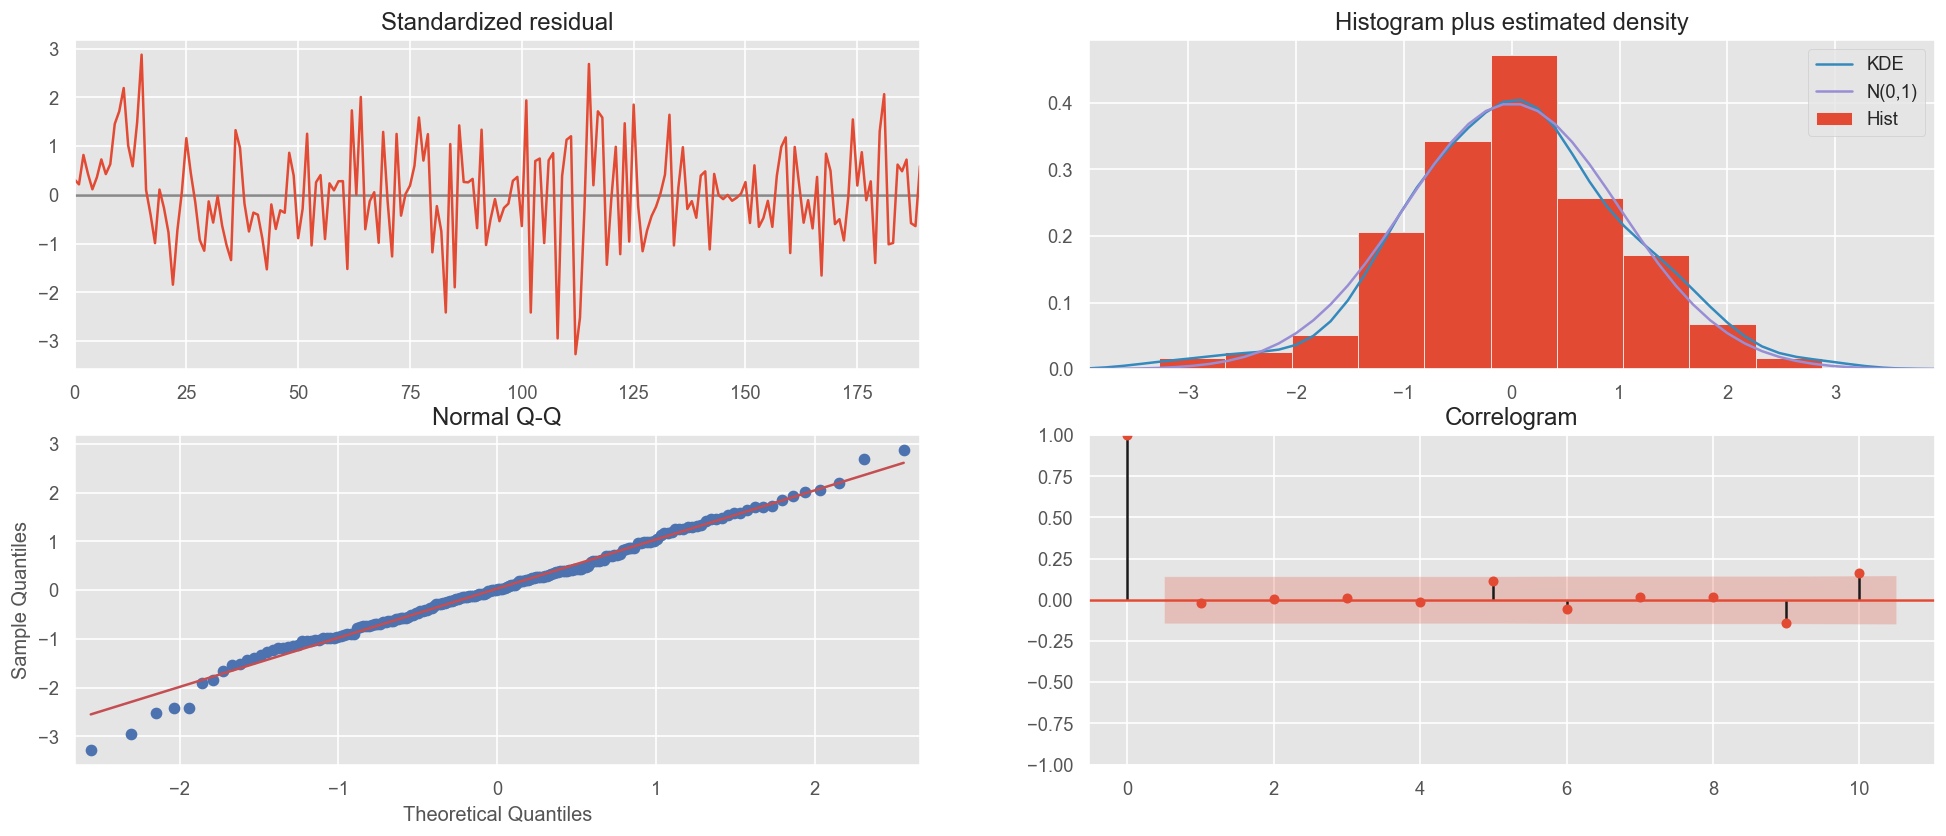

In [289]:
results.plot_diagnostics(figsize = FIG_SIZE)
plt.show()

## Time Series Prediction and Forecasting

### One-Step Ahead Prediction

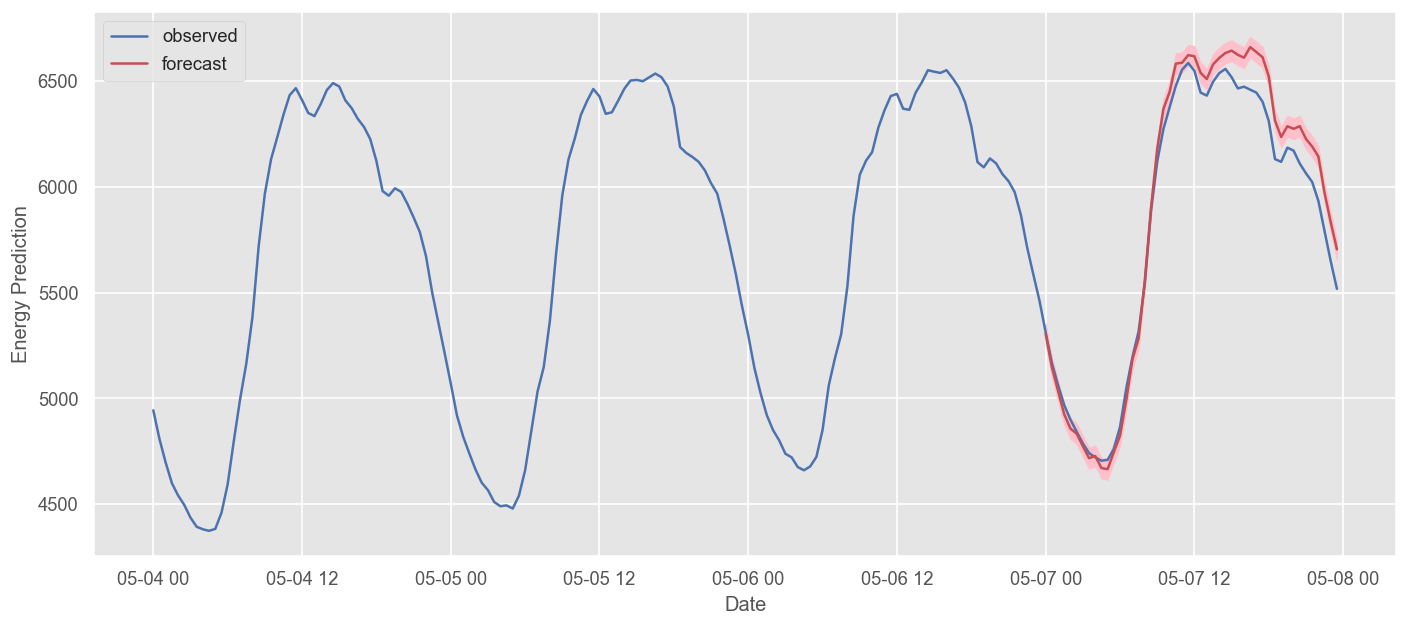

In [290]:
# Import data
series_df = demand_data_analysis.nem_demand_actual

NUM_OF_STEPS = 48
# Generate predictions
one_step_forecast = final_results.get_prediction(start=-NUM_OF_STEPS)
# Extract prediction mean
mean_forecast = one_step_forecast.predicted_mean
mean_forecast_x = demand_data_analysis.index[-NUM_OF_STEPS:]

forecast_df = pd.DataFrame(mean_forecast.to_list(), 
                           index=mean_forecast_x, columns = ['forecast'])

# Get confidence intervals of  predictions
confidence_intervals = one_step_forecast.conf_int()
# confidence_intervals
# # Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower nem_demand_actual']
upper_limits = confidence_intervals.loc[:,'upper nem_demand_actual']
conf_int_df = pd.DataFrame(list(zip(lower_limits, upper_limits)), index=mean_forecast_x, 
                           columns = ['lower_limits','upper_limits'])

plt.figure(figsize=(14,6))

# plot the amazon data
plt.plot(series_df, color='b', label='observed')

# plot your mean predictions
plt.plot(forecast_df, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(conf_int_df.index, conf_int_df.lower_limits, 
                 conf_int_df.upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('Energy Prediction')
plt.legend()
plt.show()

### Dynamic Prediction

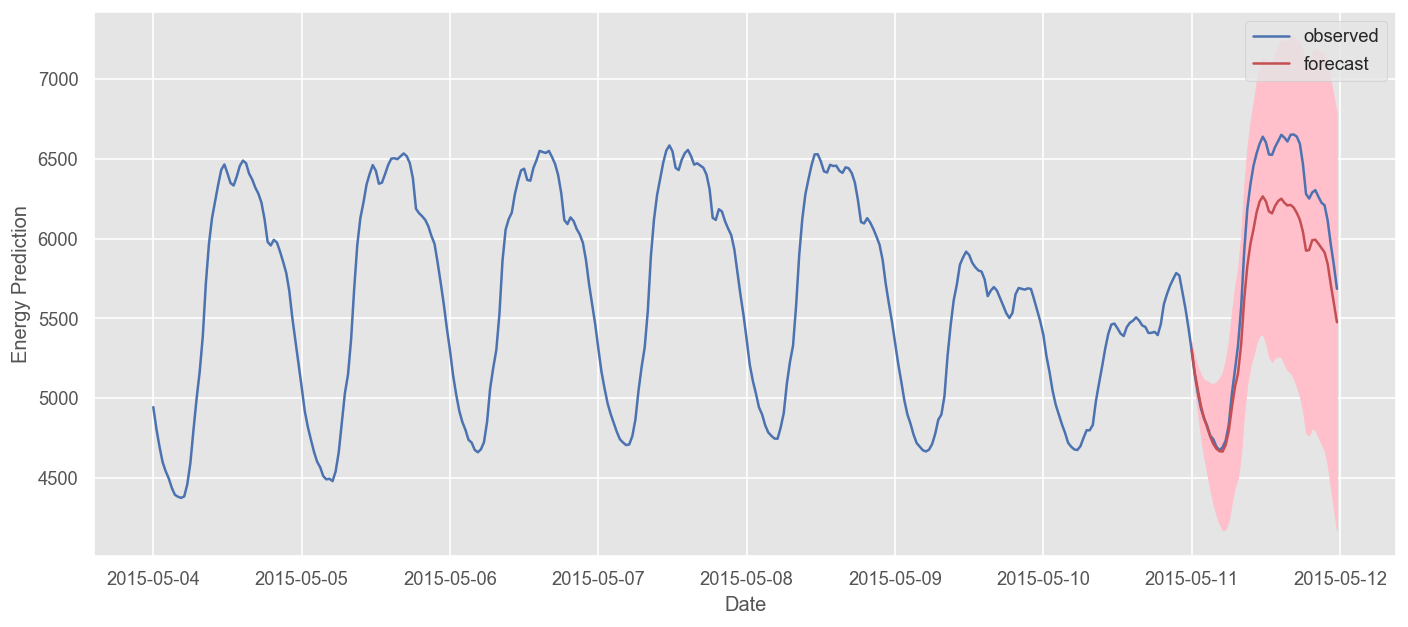

In [115]:
# Import data
series_df = demand_data_analysis.nem_demand_actual

NUM_OF_STEPS = 48
# Generate predictions
dynamic_forecast = final_results.get_prediction(start=-NUM_OF_STEPS, dynamic=True)
# Extract prediction mean
mean_forecast = dynamic_forecast.predicted_mean
mean_forecast_x = demand_data_analysis.index[-NUM_OF_STEPS:]

forecast_df = pd.DataFrame(mean_forecast.to_list(), 
                           index=mean_forecast_x, columns = ['forecast'])

# Get confidence intervals of  predictions
confidence_intervals = dynamic_forecast.conf_int()
# confidence_intervals
# # Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower nem_demand_actual']
upper_limits = confidence_intervals.loc[:,'upper nem_demand_actual']
conf_int_df = pd.DataFrame(list(zip(lower_limits, upper_limits)), index=mean_forecast_x, 
                           columns = ['lower_limits','upper_limits'])

plt.figure(figsize=(14,6))

# plot the amazon data
plt.plot(series_df, color='b', label='observed')

# plot your mean predictions
plt.plot(forecast_df, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(conf_int_df.index, conf_int_df.lower_limits, 
                 conf_int_df.upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('Energy Prediction')
plt.legend()
plt.show()

### Out-Of-Sample Forecast

In [291]:
PERIOD = '30 min'
FORECAST_DURATION = '7 day'

# Import data
series_df = demand_data_analysis.nem_demand_actual

# Creating the forecast index
from datetime import datetime, timedelta

# Set start and end dates
start = series_df.index[0]
end = series_df.index[-1]
start_forecast = end + pd.Timedelta(PERIOD)
end_forecast = end + pd.Timedelta(FORECAST_DURATION)

# Orginal and forecast index
org_datetime = pd.date_range(start, end, freq=PERIOD)
forecast_datetime = pd.date_range(start_forecast, end_forecast, freq=PERIOD)

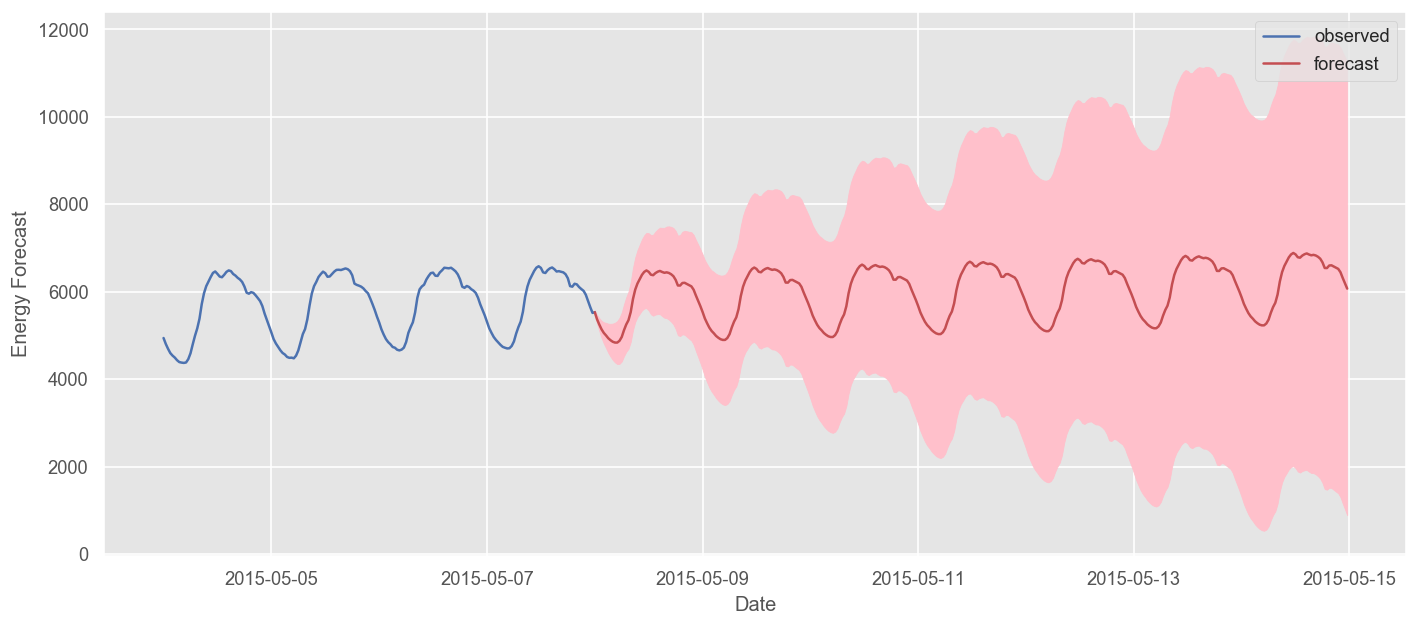

In [292]:
# Preparing the time series plots
NUM_OF_STEPS_AHEAD = len(forecast_datetime)
# Generate predictions
forecast = final_results.get_forecast(steps=NUM_OF_STEPS_AHEAD)
# Extract prediction mean
mean_forecast = forecast.predicted_mean
mead_forcast_x = forecast_datetime
forecast_df = pd.DataFrame(mean_forecast.to_list(), 
                           index=forecast_datetime, columns = ['forecast'])

# Get confidence intervals of  predictions
confidence_intervals = forecast.conf_int()
# confidence_intervals
# # Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower nem_demand_actual']
upper_limits = confidence_intervals.loc[:,'upper nem_demand_actual']
conf_int_df = pd.DataFrame(list(zip(lower_limits, upper_limits)), index=forecast_datetime, 
                           columns = ['lower_limits','upper_limits'])

## Connecting the series
series_df = pd.concat([series_df, forecast_df.forecast])[:len(series_df)+1]

plt.figure(figsize=(14,6))

# plot the amazon data
plt.plot(series_df, color='b', label='observed')

# plot your mean predictions
plt.plot(forecast_df, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(conf_int_df.index, conf_int_df.lower_limits, 
                 conf_int_df.upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('Energy Forecast')
plt.legend()
plt.show()

## Creating an weekday exogenous variable

In [117]:
def mapweekend(i):
    out = 3
    if i == 5:
        out = 2
    elif i == 6:
        out = 1
    return out

In [163]:
full_datetime = pd.date_range(start, end_forecast, freq=PERIOD)
exog_full = pd.DataFrame(list(full_datetime.dayofweek), index=full_datetime, columns=['dayofweek'])
exog_full['dayofweek'] = exog_full['dayofweek'].apply(mapweekend)
exog_full = exog_full.dayofweek.reset_index(drop=True)

exog_org = exog_full[:series_df.shape[0]]
exog_forecast = exog_full[series_df.shape[0]:]

## Introducing an exogenous variable to the SARIMAX model

In [186]:
exog = exog_org

In [192]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Import data
series = demand_data_analysis.nem_demand_actual.interpolate().reset_index(drop=True)

# Create empty list to store search results
order_aic_bic=[]

for p in range(3):
    for q in range(3):
        for d in range(1,3):
            print('Processing {},{},{}...'.format(p,d,q))
            # create and fit ARMA(p,d,q) model
            model = SARIMAX(series, order=(p,d,q), exog=exog)
            results = model.fit()

            # Append order and results tuple
            order_aic_bic.append((p, d, q, results.aic, results.bic))

# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic, columns=['p', 'd', 'q', 'AIC', 'BIC'])

Processing 0,1,0...
Processing 0,2,0...
Processing 0,1,1...


/Users/chancheefoong/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Processing 0,2,1...
Processing 0,1,2...
Processing 0,2,2...
Processing 1,1,0...
Processing 1,2,0...
Processing 1,1,1...
Processing 1,2,1...
Processing 1,1,2...
Processing 1,2,2...
Processing 2,1,0...
Processing 2,2,0...
Processing 2,1,1...
Processing 2,2,1...
Processing 2,1,2...
Processing 2,2,2...


In [193]:
# Print order_df in order of increasing AIC
order_df.sort_values('AIC').head()

,p,d,q,AIC,BIC
10,1,1,2,4053.393866,4073.134041
13,2,2,0,4053.433253,4069.214935
16,2,1,2,4054.947270,4078.635480
15,2,2,1,4055.081078,4074.808181
14,2,1,1,4056.194054,4075.934229


In [194]:
# Print order_df in order of increasing AIC
order_df.sort_values('BIC').head()

,p,d,q,AIC,BIC
13,2,2,0,4053.433253,4069.214935
10,1,1,2,4053.393866,4073.134041
8,1,1,1,4057.485409,4073.277549
15,2,2,1,4055.081078,4074.808181
14,2,1,1,4056.194054,4075.934229


In [195]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

DIFF = decompfreq
ns_order = (1,1,2)

# Import data
series = demand_data_analysis.nem_demand_actual.interpolate().reset_index(drop=True)

# Create empty list to store search results
order_aic_bic_seasonal=[]

for P in range(3):
    for Q in range(3):
        for D in range(2):
            print('Processing {},{},{}...'.format(P,D,Q))

            # create and fit SARIMAX(p,d,q,P,D,Q,DIFF) model
            model = SARIMAX(series, order=ns_order, seasonal_order=(P,D,Q,DIFF), exog=exog)
            try:
                results = model.fit()

                # Append order and results tuple
                order_aic_bic_seasonal.append((P, D, Q, results.aic, results.bic))
            except:
                pass
            
# Construct DataFrame from order_aic_bic
order_seasonal_df = pd.DataFrame(order_aic_bic_seasonal, columns=['P', 'D', 'Q', 'AIC', 'BIC'])

Processing 0,0,0...
Processing 0,1,0...
Processing 0,0,1...
Processing 0,1,1...
Processing 0,0,2...


/Users/chancheefoong/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Processing 0,1,2...
Processing 1,0,0...
Processing 1,1,0...
Processing 1,0,1...
Processing 1,1,1...
Processing 1,0,2...
Processing 1,1,2...


/Users/chancheefoong/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/chancheefoong/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Processing 2,0,0...
Processing 2,1,0...
Processing 2,0,1...
Processing 2,1,1...


/Users/chancheefoong/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Processing 2,0,2...
Processing 2,1,2...


/Users/chancheefoong/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [196]:
# Print order_df in order of increasing AIC
order_seasonal_df.sort_values('AIC').head()

,P,D,Q,AIC,BIC
5,0,1,2,3174.505955,3201.204868
9,1,1,1,3175.280076,3201.978990
15,2,1,1,3175.280666,3205.793710
17,2,1,2,3175.728161,3210.055336
11,1,1,2,3175.757494,3206.270538


In [197]:
# Print order_df in order of increasing AIC
order_seasonal_df.sort_values('BIC').head()

,P,D,Q,AIC,BIC
5,0,1,2,3174.505955,3201.204868
3,0,1,1,3178.558702,3201.443486
9,1,1,1,3175.280076,3201.978990
15,2,1,1,3175.280666,3205.793710
11,1,1,2,3175.757494,3206.270538


In [187]:
results_auto_x = pm.auto_arima(series, d=1, start_p=1, start_q=1, max_p=4, max_q=4, # non-seasonal arguments
                        seasonal=True, m=48, D=1, start_P=1, start_Q=1, max_P=4, max_Q=4,
                        exogenous=np.array(exog).reshape(-1, 1),
                        information_criterion='aic', # used to select best model
                        trace=True,                  # print results whilst training
                        error_action='ignore',       # ignore orders that don't work
                        stepwise=True,)

Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(1, 1, 1, 48) (constant=True); AIC=3175.441, BIC=3202.140, Time=30.954 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 48) (constant=True); AIC=3481.814, BIC=3493.256, Time=1.011 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 0, 48) (constant=True); AIC=3237.615, BIC=3256.686, Time=20.389 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 1, 48) (constant=True); AIC=3261.614, BIC=3280.685, Time=19.173 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 48); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.993)
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 48) (constant=False); AIC=3479.854, BIC=3487.483, Time=3.628 seconds
Fit ARIMA: (1, 1, 1)x(0, 1, 1, 48) (constant=True); AIC=3178.892, BIC=3201.776, Time=23.932 seconds
Near non-invertible roots for order (1, 1, 1)(0, 1, 1, 48); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (1, 1, 1)x(1, 1, 0, 48) (cons

/Users/chancheefoong/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/chancheefoong/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fit ARIMA: (1, 1, 1)x(1, 1, 2, 48) (constant=True); AIC=3175.833, BIC=3206.346, Time=115.587 seconds
Near non-invertible roots for order (1, 1, 1)(1, 1, 2, 48); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (1, 1, 1)x(0, 1, 0, 48) (constant=True); AIC=3284.701, BIC=3303.771, Time=4.738 seconds


/Users/chancheefoong/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fit ARIMA: (1, 1, 1)x(0, 1, 2, 48) (constant=True); AIC=3174.658, BIC=3201.357, Time=76.943 seconds
Near non-invertible roots for order (1, 1, 1)(0, 1, 2, 48); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)


/Users/chancheefoong/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: (1, 1, 1)x(2, 1, 0, 48) (constant=True); AIC=3202.583, BIC=3229.282, Time=100.856 seconds


/Users/chancheefoong/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/chancheefoong/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/chancheefoong/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: (1, 1, 1)x(2, 1, 2, 48) (constant=True); AIC=3175.298, BIC=3209.626, Time=301.305 seconds
Near non-invertible roots for order (1, 1, 1)(2, 1, 2, 48); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)


/Users/chancheefoong/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: (0, 1, 1)x(1, 1, 1, 48) (constant=True); AIC=3255.107, BIC=3277.991, Time=38.481 seconds
Near non-invertible roots for order (0, 1, 1)(1, 1, 1, 48); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (1, 1, 0)x(1, 1, 1, 48) (constant=True); AIC=3175.953, BIC=3198.838, Time=25.004 seconds
Near non-invertible roots for order (1, 1, 0)(1, 1, 1, 48); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)


/Users/chancheefoong/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: (2, 1, 1)x(1, 1, 1, 48) (constant=True); AIC=3177.362, BIC=3207.875, Time=45.678 seconds
Near non-invertible roots for order (2, 1, 1)(1, 1, 1, 48); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (1, 1, 2)x(1, 1, 1, 48) (constant=True); AIC=3177.258, BIC=3207.771, Time=47.289 seconds
Near non-invertible roots for order (1, 1, 2)(1, 1, 1, 48); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 1, 0)x(1, 1, 1, 48) (constant=True); AIC=3407.068, BIC=3426.139, Time=20.545 seconds
Near non-invertible roots for order (0, 1, 0)(1, 1, 1, 48); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 1, 2)x(1, 1, 1, 48) (constant=True); AIC=3229.059, BIC=3255.758, Time=33.548 seconds
Near non-invertible roots for order (0, 1, 2)(1, 1, 1, 48); setting score to inf (at least one inverse root too close to th

/Users/chancheefoong/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/chancheefoong/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/chancheefoong/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: (2, 1, 2)x(1, 1, 1, 48) (constant=True); AIC=3174.882, BIC=3209.210, Time=60.258 seconds
Near non-invertible roots for order (2, 1, 2)(1, 1, 1, 48); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Total fit time: 1139.718 seconds


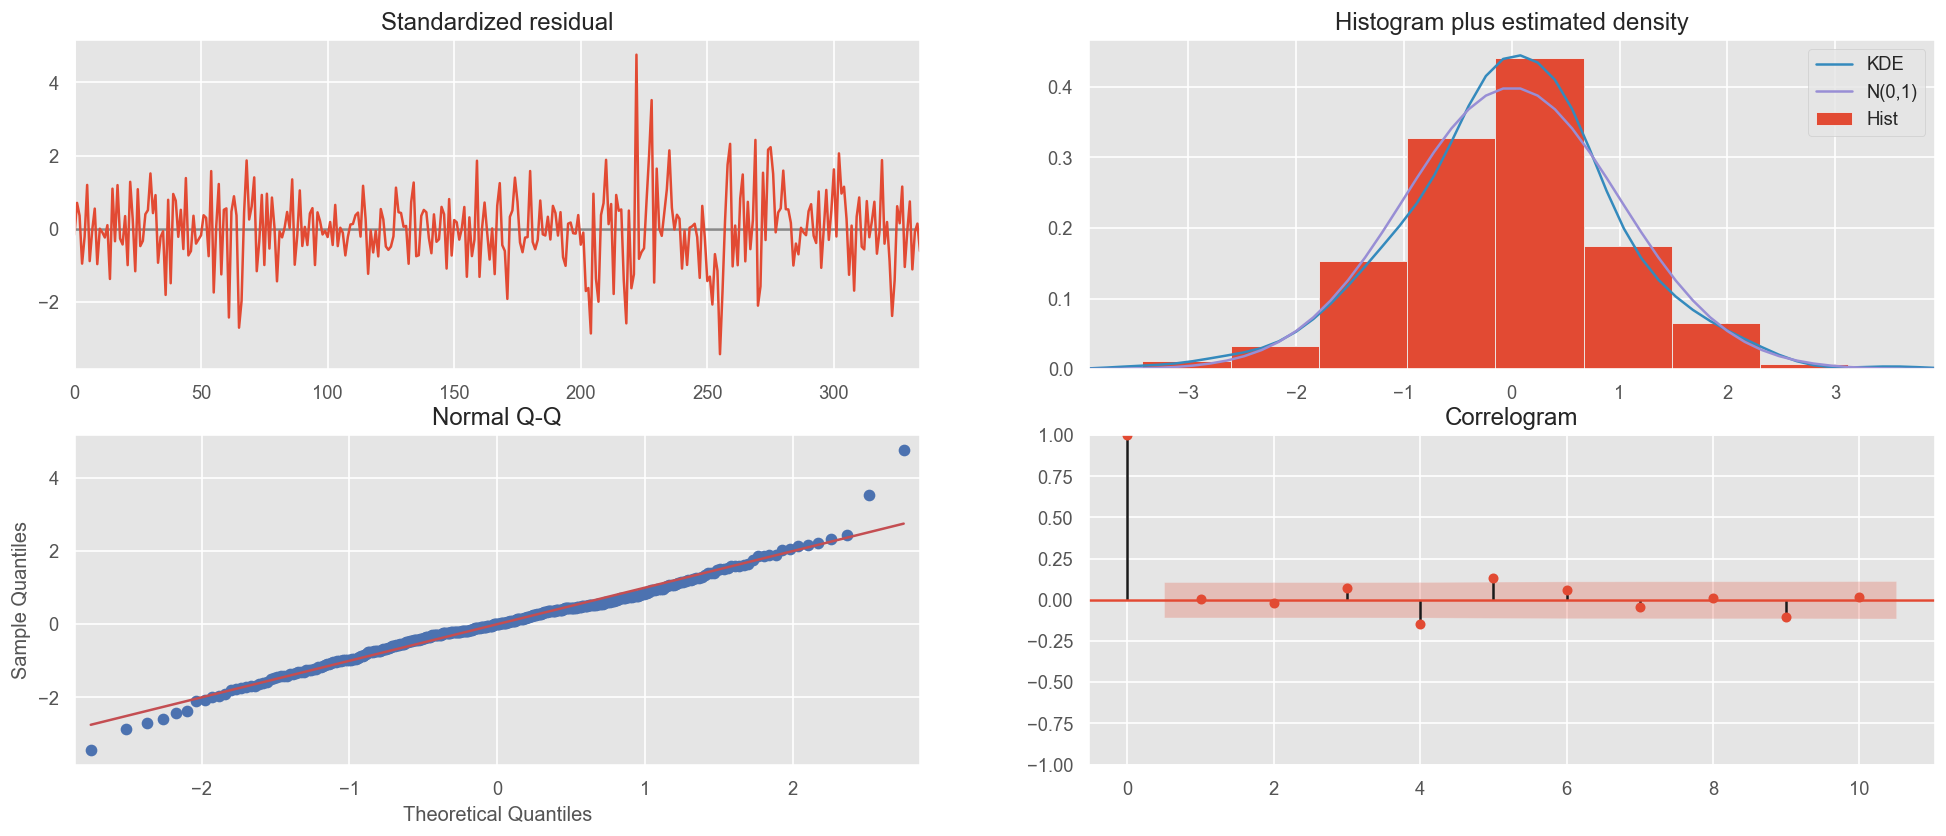

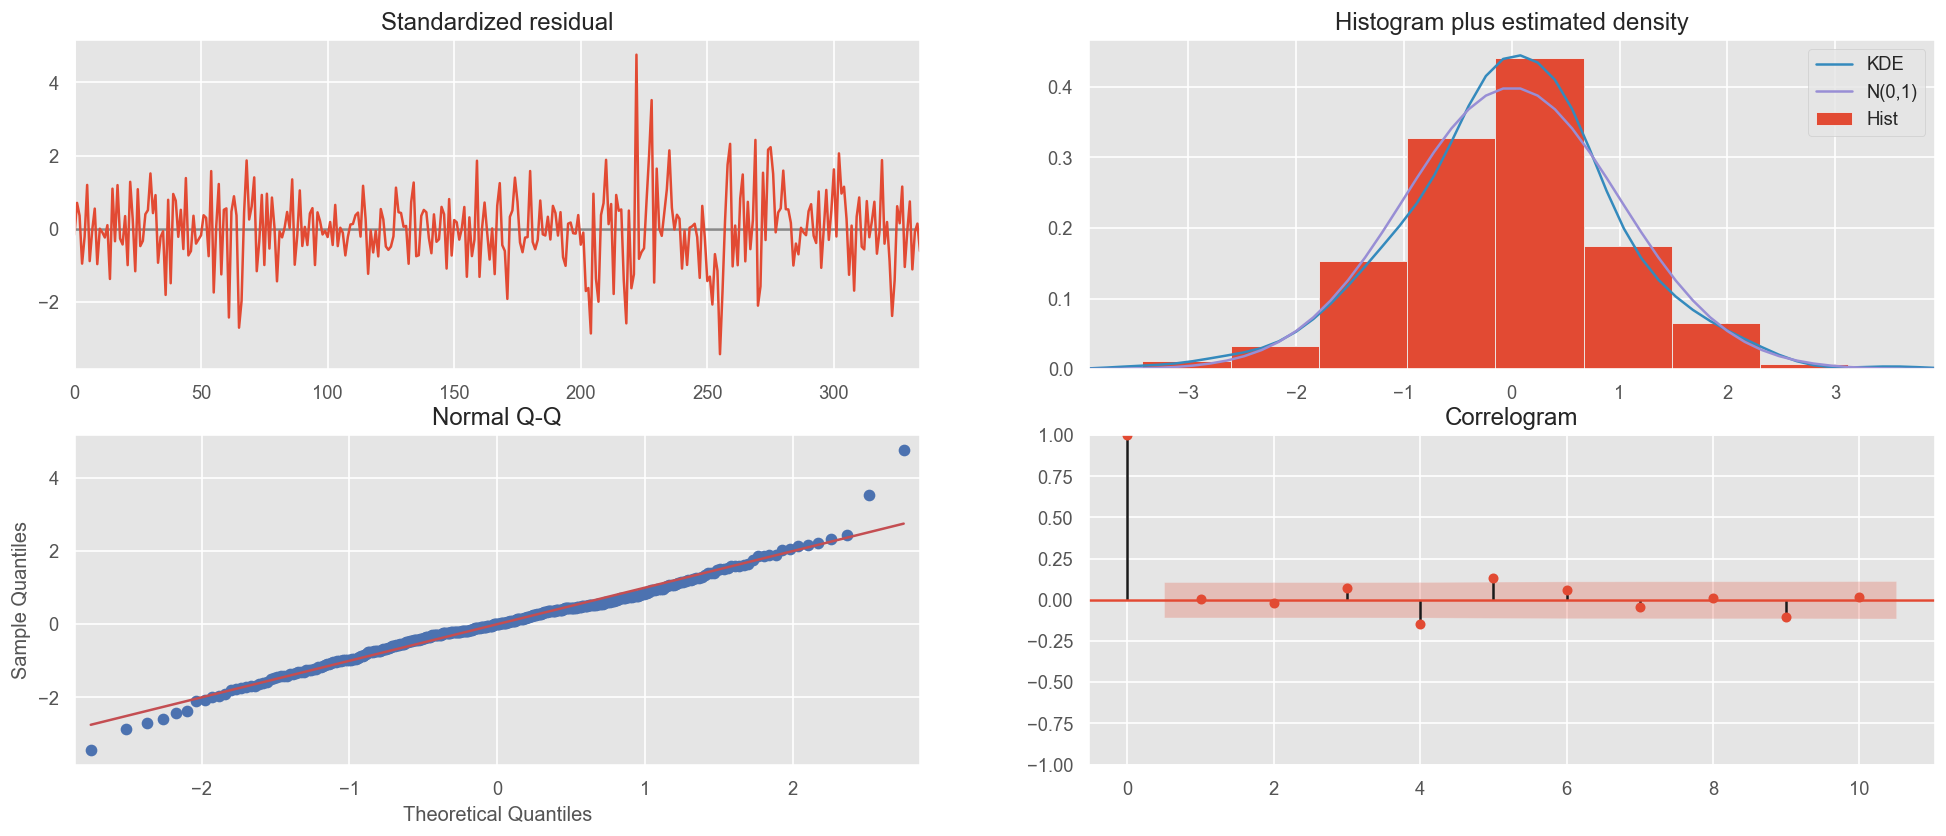

In [190]:
results_auto_x.plot_diagnostics(figsize=FIG_SIZE)

In [191]:
results_auto_x.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  384
Model:             SARIMAX(1, 1, 1)x(0, 1, [1, 2], 48)   Log Likelihood               -1580.329
Date:                                 Wed, 18 Mar 2020   AIC                           3174.658
Time:                                         11:16:38   BIC                           3201.357
Sample:                                              0   HQIC                          3185.303
                                                 - 384                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0704      0.503     -0.140      0.889      -1.056       0.915
x1            -3.9931     41.552     -0.096      0.923     -85.434      77.448
ar.L1          0.7757      0.039     19.910      0.000       0.699       0.852
ma.L1         -0.1260      0.068     -1.853      0.064      -0.259       0.007
ma.S.L48      -0.8413    257.414     -0.003      0.997    -505.364     503.681
ma.S.L96      -0.1586     40.923     -0.004      0.997     -80.367      80.050
sigma2       562.2217   1.45e+05      0.004      0.997   -2.83e+05    2.84e+05
===================================================================================
Ljung-Box (Q):                       55.90   Jarque-Bera (JB):                49.53
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               1.78   Skew:                             0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [198]:
# Create a SARIMAX model
final_model_x = SARIMAX(series, order=(1,1,2), seasonal_order=(0,1,2,48), exog=exog)

# Fit the model
final_results_x = final_model_x.fit()

# Print the results summary
print(final_results_x.summary())

                                     SARIMAX Results                                      
Dep. Variable:                  nem_demand_actual   No. Observations:                  384
Model:             SARIMAX(1, 1, 2)x(0, 1, 2, 48)   Log Likelihood               -1580.253
Date:                            Wed, 18 Mar 2020   AIC                           3174.506
Time:                                    11:49:57   BIC                           3201.205
Sample:                                         0   HQIC                          3185.150
                                            - 384                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dayofweek     -4.1481     39.634     -0.105      0.917     -81.829      73.532
ar.L1          0.7928      0.049   

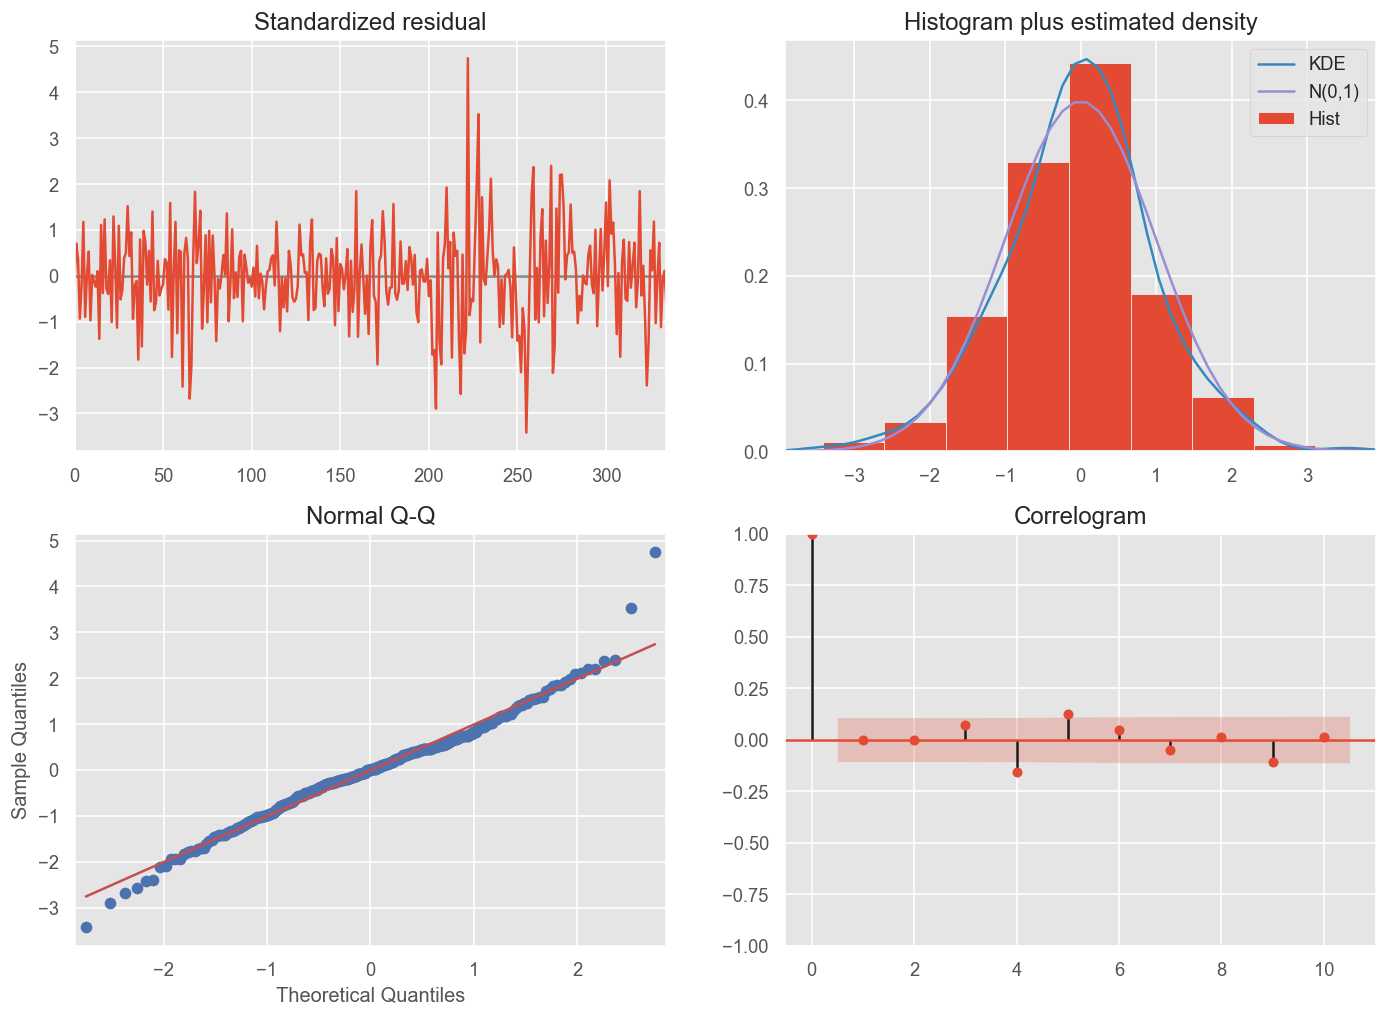

In [199]:
final_results_x.plot_diagnostics(figsize=(14,10))
plt.show()

## One-Step-Ahead Prediction

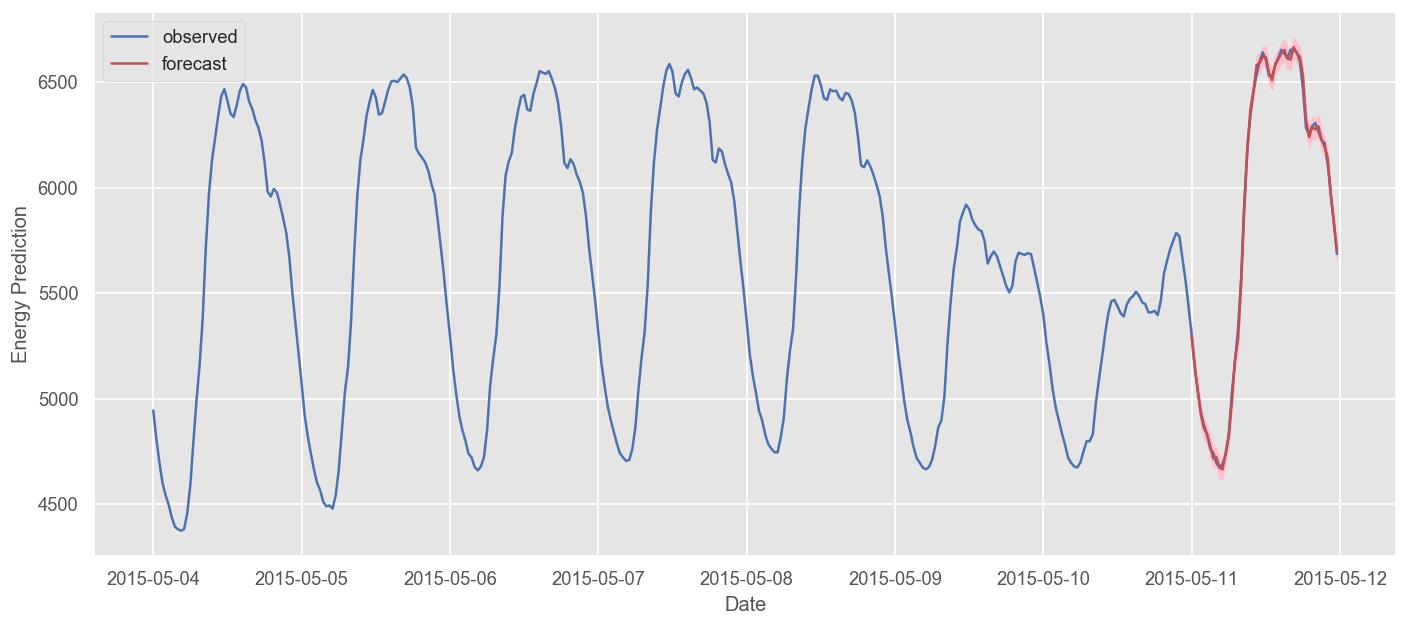

In [200]:
# Import data
series_df = demand_data_analysis.nem_demand_actual

NUM_OF_STEPS = 48
# Generate predictions
one_step_forecast = final_results_x.get_prediction(start=-NUM_OF_STEPS, exog=exog)
# Extract prediction mean
mean_forecast = one_step_forecast.predicted_mean
mean_forecast_x = demand_data_analysis.index[-NUM_OF_STEPS:]

forecast_df = pd.DataFrame(mean_forecast.to_list(), 
                           index=mean_forecast_x, columns = ['forecast'])

# Get confidence intervals of  predictions
confidence_intervals = one_step_forecast.conf_int()
# confidence_intervals
# # Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower nem_demand_actual']
upper_limits = confidence_intervals.loc[:,'upper nem_demand_actual']
conf_int_df = pd.DataFrame(list(zip(lower_limits, upper_limits)), index=mean_forecast_x, 
                           columns = ['lower_limits','upper_limits'])

plt.figure(figsize=(14,6))

# plot the amazon data
plt.plot(series_df, color='b', label='observed')

# plot your mean predictions
plt.plot(forecast_df, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(conf_int_df.index, conf_int_df.lower_limits, 
                 conf_int_df.upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('Energy Prediction')
plt.legend()
plt.show()

## Dynamic Prediction

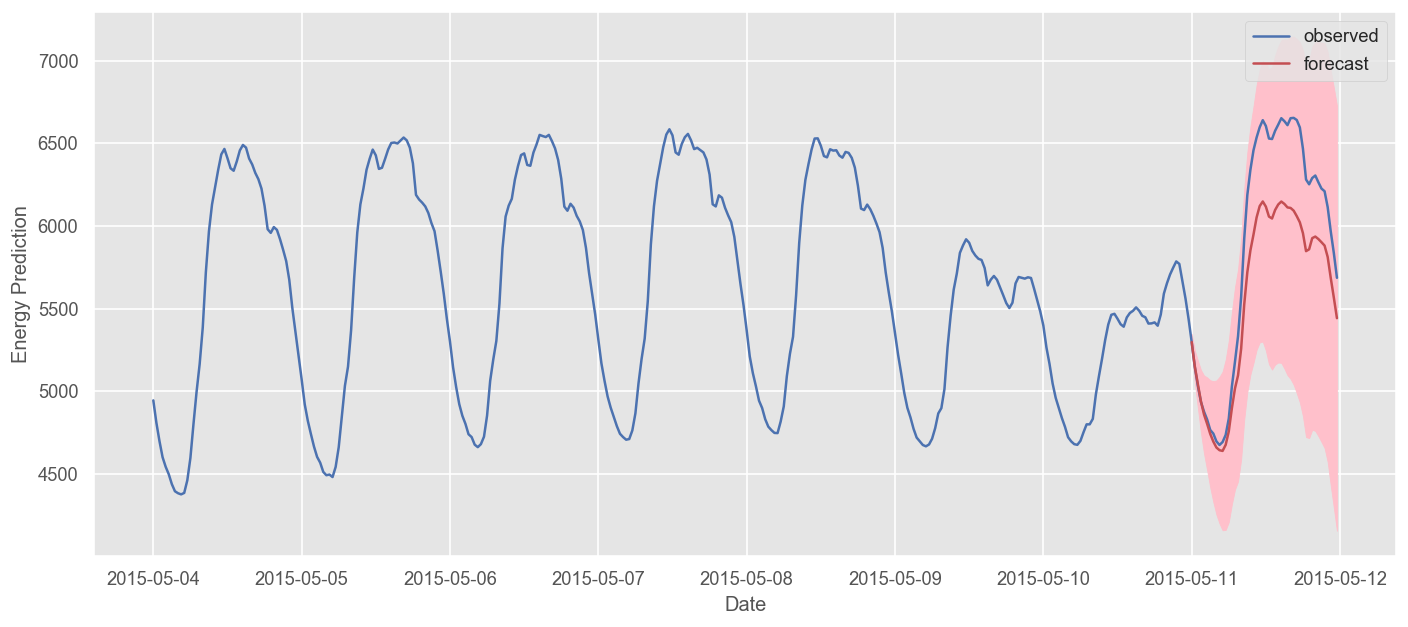

In [201]:
# Import data
series_df = demand_data_analysis.nem_demand_actual

NUM_OF_STEPS = 48
# Generate predictions
dynamic_forecast = final_results_x.get_prediction(start=-NUM_OF_STEPS, dynamic=True, exog=exog)
# Extract prediction mean
mean_forecast = dynamic_forecast.predicted_mean
mean_forecast_x = demand_data_analysis.index[-NUM_OF_STEPS:]

forecast_df = pd.DataFrame(mean_forecast.to_list(), 
                           index=mean_forecast_x, columns = ['forecast'])

# Get confidence intervals of  predictions
confidence_intervals = dynamic_forecast.conf_int()
# confidence_intervals
# # Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower nem_demand_actual']
upper_limits = confidence_intervals.loc[:,'upper nem_demand_actual']
conf_int_df = pd.DataFrame(list(zip(lower_limits, upper_limits)), index=mean_forecast_x, 
                           columns = ['lower_limits','upper_limits'])

plt.figure(figsize=(14,6))

# plot the amazon data
plt.plot(series_df, color='b', label='observed')

# plot your mean predictions
plt.plot(forecast_df, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(conf_int_df.index, conf_int_df.lower_limits, 
                 conf_int_df.upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('Energy Prediction')
plt.legend()
plt.show()

## Out-Of-Sample Forecast

In [202]:
PERIOD = '30 min'
FORECAST_DURATION = '7 day'

# Import data
series_df = demand_data_analysis.nem_demand_actual

# Creating the forecast index
from datetime import datetime, timedelta

# Set start and end dates
start = series_df.index[0]
end = series_df.index[-1]
start_forecast = end + pd.Timedelta(PERIOD)
end_forecast = end + pd.Timedelta(FORECAST_DURATION)

# Orginal and forecast index
org_datetime = pd.date_range(start, end, freq=PERIOD)
forecast_datetime = pd.date_range(start_forecast, end_forecast, freq=PERIOD)

exog = exog_forecast

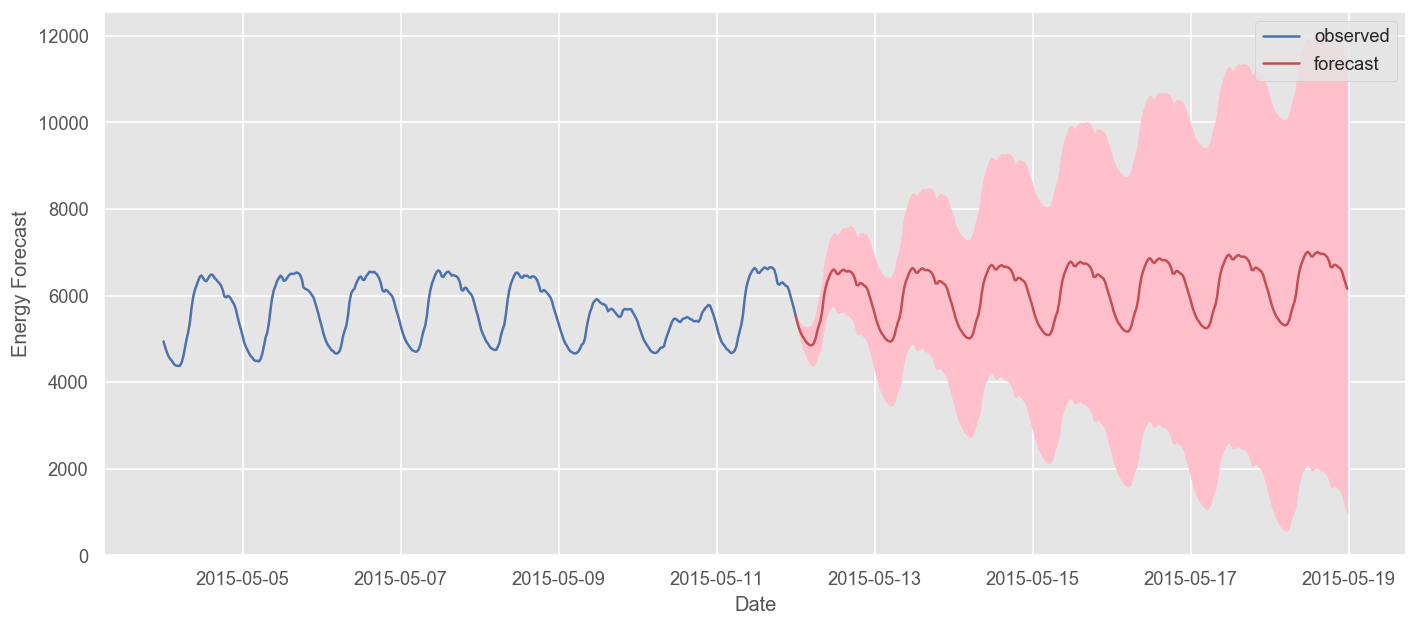

In [203]:
# Preparing the time series plots
NUM_OF_STEPS_AHEAD = len(forecast_datetime)
# Generate predictions
forecast = final_results_x.get_forecast(steps=NUM_OF_STEPS_AHEAD, exog=exog)
# Extract prediction mean
mean_forecast = forecast.predicted_mean
mead_forcast_x = forecast_datetime
forecast_df = pd.DataFrame(mean_forecast.to_list(), 
                           index=forecast_datetime, columns = ['forecast'])

# Get confidence intervals of  predictions
confidence_intervals = forecast.conf_int()
# confidence_intervals
# # Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower nem_demand_actual']
upper_limits = confidence_intervals.loc[:,'upper nem_demand_actual']
conf_int_df = pd.DataFrame(list(zip(lower_limits, upper_limits)), index=forecast_datetime, 
                           columns = ['lower_limits','upper_limits'])

## Connecting the series
series_df = pd.concat([series_df, forecast_df.forecast])[:len(series_df)+1]

plt.figure(figsize=(14,6))

# plot the amazon data
plt.plot(series_df, color='b', label='observed')

# plot your mean predictions
plt.plot(forecast_df, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(conf_int_df.index, conf_int_df.lower_limits, 
                 conf_int_df.upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('Energy Forecast')
plt.legend()
plt.show()